In [ ]:
import  os
import  joblib

import  pandas                      as      pd
import  numpy                       as      np
import  seaborn                     as      sns
import  tensorflow                  as      tf
import  matplotlib                  as      mpl
import  matplotlib.pyplot           as      plt
import  tensorflow.keras.backend    as K

from    warnings                import  simplefilter

from    sklearn.svm             import  SVC
from    sklearn.tree            import  DecisionTreeClassifier, plot_tree
from    sklearn.base            import  BaseEstimator, ClassifierMixin
from    sklearn.metrics         import  accuracy_score, classification_report, confusion_matrix, roc_auc_score, top_k_accuracy_score
from    sklearn.ensemble        import  RandomForestClassifier
from    sklearn.neighbors       import  KNeighborsClassifier
from    sklearn.linear_model    import  LogisticRegression
from    sklearn.preprocessing   import  OneHotEncoder, LabelEncoder, MultiLabelBinarizer
from    sklearn.neural_network  import  MLPClassifier
from    sklearn.model_selection import  GridSearchCV, StratifiedKFold, train_test_split

from    tensorflow.keras                import Sequential
from    tensorflow.keras.layers         import Input, Dense, Dropout
from    tensorflow.keras.callbacks      import EarlyStopping
from    tensorflow.keras.regularizers   import l2

# Set high-resolution matplotlib plots
mpl.rcParams['figure.dpi'] = 300

# Set the random seed for reproducibility
np.random.seed(42)

# Disable scikit warnings
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

### **Data Pre-Processing**

In [359]:
# Load dataset file
dataset = pd.read_csv(r"./Dataset/dataset.csv")

In [360]:
# Define a cleaning function to remove spaces from the beginning and end of strings
def clean_data(x):                 
    # Check if input is string                                                           
    if isinstance(x, str):
        return x.strip().replace("  ", " ").replace(" _", "_").replace("_ ", "_")
    else:
        return x  

# Apply the function to each column
for col in dataset.columns:
    dataset[col] = dataset[col].map(clean_data)

# List of all symptom columns
symptom_cols = [
    'Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5',
    'Symptom_6', 'Symptom_7', 'Symptom_8', 'Symptom_9', 'Symptom_10',
    'Symptom_11', 'Symptom_12', 'Symptom_13', 'Symptom_14', 'Symptom_15',
    'Symptom_16', 'Symptom_17'
]
# Create the empty list to store all symptoms
all_symptoms = []

for col in symptom_cols:                           # go through each Symptom_1 to Symptom_17 column
    for symptom in dataset[col]:                   # go through every value in that column
        if pd.notna(symptom):                      # check if the cell is not nan
            all_symptoms.append(symptom)           # add it to the list

unique_symptoms = sorted(list(set(all_symptoms)))  #to remove the duplicates with set, we make them again a list (makes it usable for indexing and loops) and we soort them alphabetically in order to read them easier

# Create a list of all diseases
disease_list = dataset['Disease'].unique()      #we use the unique function to get all diseases

# Print how many symptoms we found
print("Number of unique symptoms:", len(unique_symptoms))
print("Symptoms:", unique_symptoms)

print("Number of unique diseases:", len(disease_list))
print("Symptoms:", disease_list)

Number of unique symptoms: 131
Symptoms: ['abdominal_pain', 'abnormal_menstruation', 'acidity', 'acute_liver_failure', 'altered_sensorium', 'anxiety', 'back_pain', 'belly_pain', 'blackheads', 'bladder_discomfort', 'blister', 'blood_in_sputum', 'bloody_stool', 'blurred_and_distorted_vision', 'breathlessness', 'brittle_nails', 'bruising', 'burning_micturition', 'chest_pain', 'chills', 'cold_hands_and_feets', 'coma', 'congestion', 'constipation', 'continuous_feel_of_urine', 'continuous_sneezing', 'cough', 'cramps', 'dark_urine', 'dehydration', 'depression', 'diarrhoea', 'dischromic_patches', 'distention_of_abdomen', 'dizziness', 'drying_and_tingling_lips', 'enlarged_thyroid', 'excessive_hunger', 'extra_marital_contacts', 'family_history', 'fast_heart_rate', 'fatigue', 'fluid_overload', 'foul_smell_of urine', 'headache', 'high_fever', 'hip_joint_pain', 'history_of_alcohol_consumption', 'increased_appetite', 'indigestion', 'inflammatory_nails', 'internal_itching', 'irregular_sugar_level', '

In [361]:
binary = pd.DataFrame()                  #Create a new, empty table (DataFrame) named binary to hold the simplified data
binary['Disease'] = dataset['Disease']  #Copy the disease column from the original dataset (dataset) into the binary table

# For each syptom we check each row (one-hot encoding)
for symptom in unique_symptoms:
    binary[symptom] = dataset[symptom_cols].eq(symptom).any(axis=1).astype(int)
# For each symptom in list, check every patient.
# and set 1 if the patient has this symptom anywhere, or 0 if not

# Prepare the data
X_binary = binary.drop(columns=['Disease'])     # All columns except Disease
y_binary = binary['Disease']                    # Target column

# Split the data into training and testing sets (70% train, 30% test)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_binary, y_binary, train_size = 0.7, test_size=0.3, random_state=42)

### **Decision Tree**

In [326]:
# Define parameters for the Decision Tree model
param_grid = {'ccp_alpha': [0.1, .01, .001, .0001],
              'max_depth' : range(15,25,1),
              'criterion' :['gini', 'entropy','log_loss'],
             }

# Initialize the Decision Tree model
model = DecisionTreeClassifier(random_state=42)
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=True)
# Fit the model to the training data
grid_search.fit(X_train_bin, y_train_bin)

# Get the best model from grid search
final_model = grid_search.best_estimator_

# Save the model
joblib.dump(final_model, './Models_Fulldata/decision_tree_model.pkl')
# Print the best parameters
print(final_model)

# Train the final model on the training data
final_model.fit(X_train_bin, y_train_bin)

# Prediction on the test set
predictions = final_model.predict(X_test_bin)

# Evaluation
print(classification_report(y_test_bin, predictions))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
DecisionTreeClassifier(ccp_alpha=0.0001, criterion='entropy', max_depth=24,
                       random_state=42)
                                        precision    recall  f1-score   support

(vertigo) Paroymsal Positional Vertigo       1.00      1.00      1.00        32
                                  AIDS       1.00      1.00      1.00        39
                                  Acne       1.00      1.00      1.00        41
                   Alcoholic hepatitis       1.00      1.00      1.00        36
                               Allergy       1.00      1.00      1.00        35
                             Arthritis       1.00      1.00      1.00        36
                      Bronchial Asthma       1.00      1.00      1.00        44
                  Cervical spondylosis       1.00      1.00      1.00        32
                           Chicken pox       1.00      1.00      1.00        35
                   C

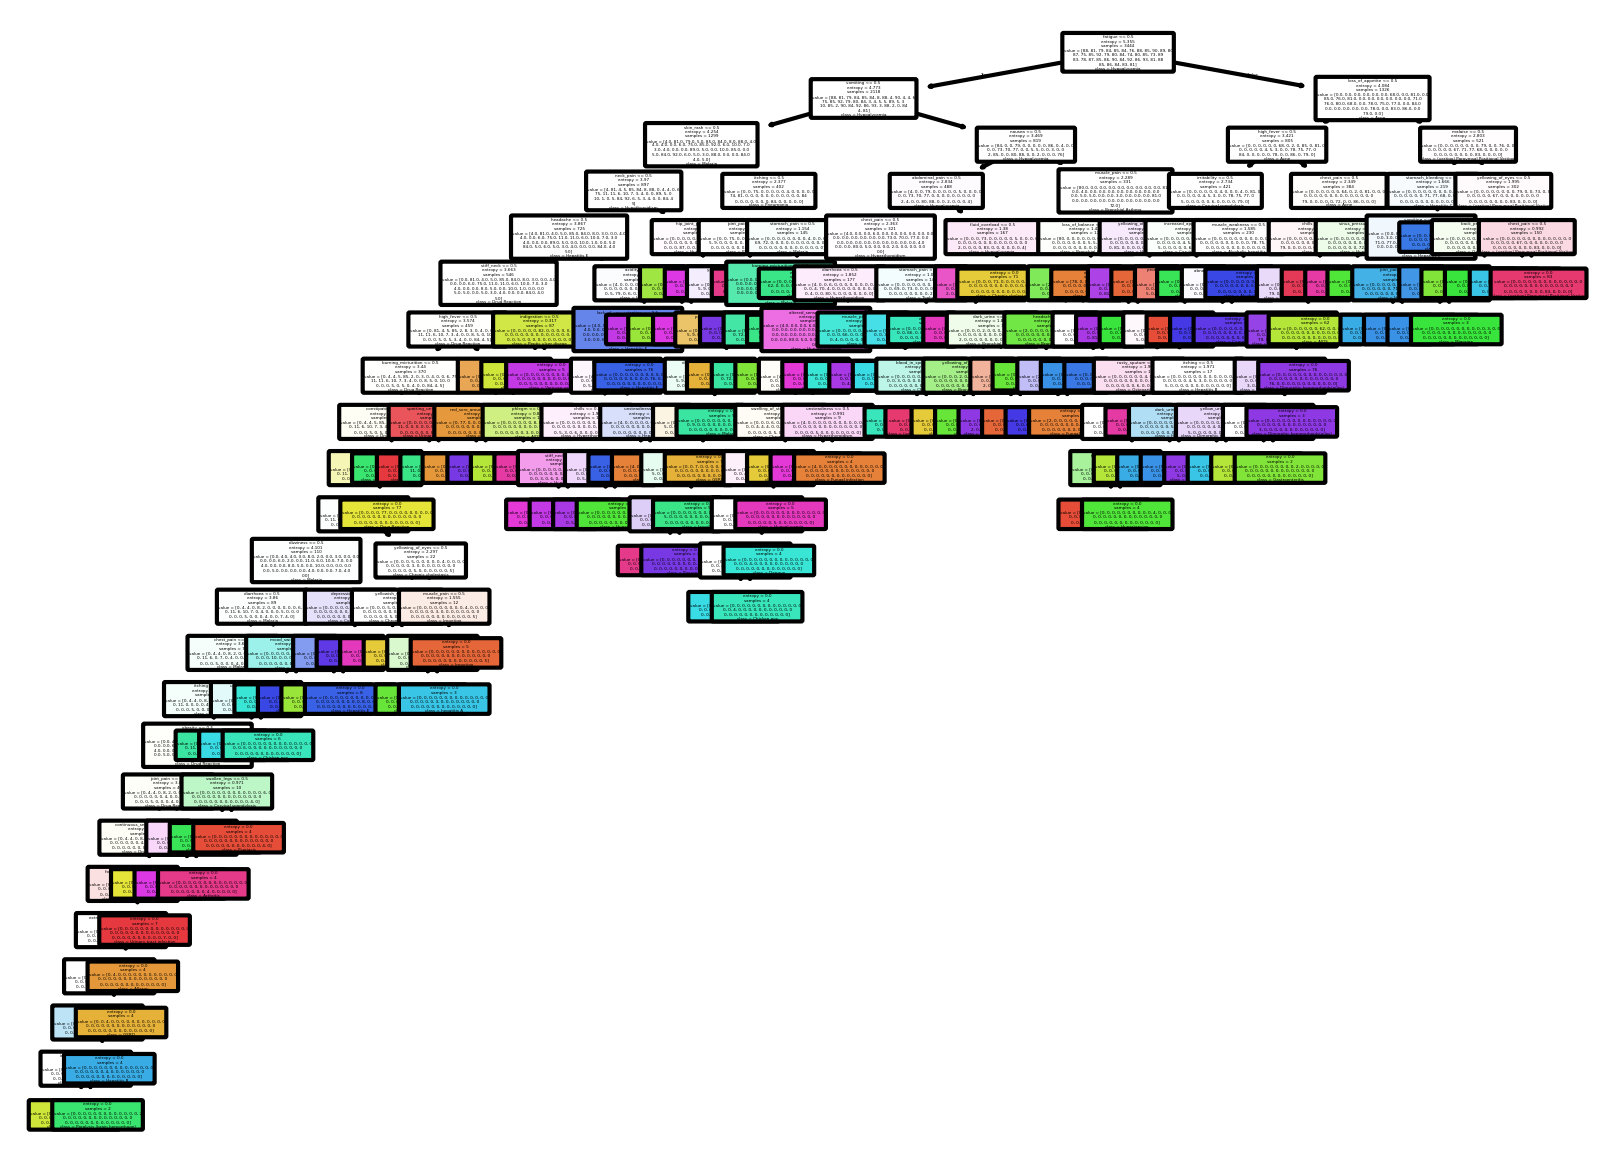

In [327]:
# Plot tree graph
plot_tree(final_model, filled=True, feature_names=X_binary.columns, class_names=y_binary.unique(), rounded=True)
# Show the plot
plt.show()
# plt.savefig("./Plots/Classifier_Fulldata/decision_tree.pdf")

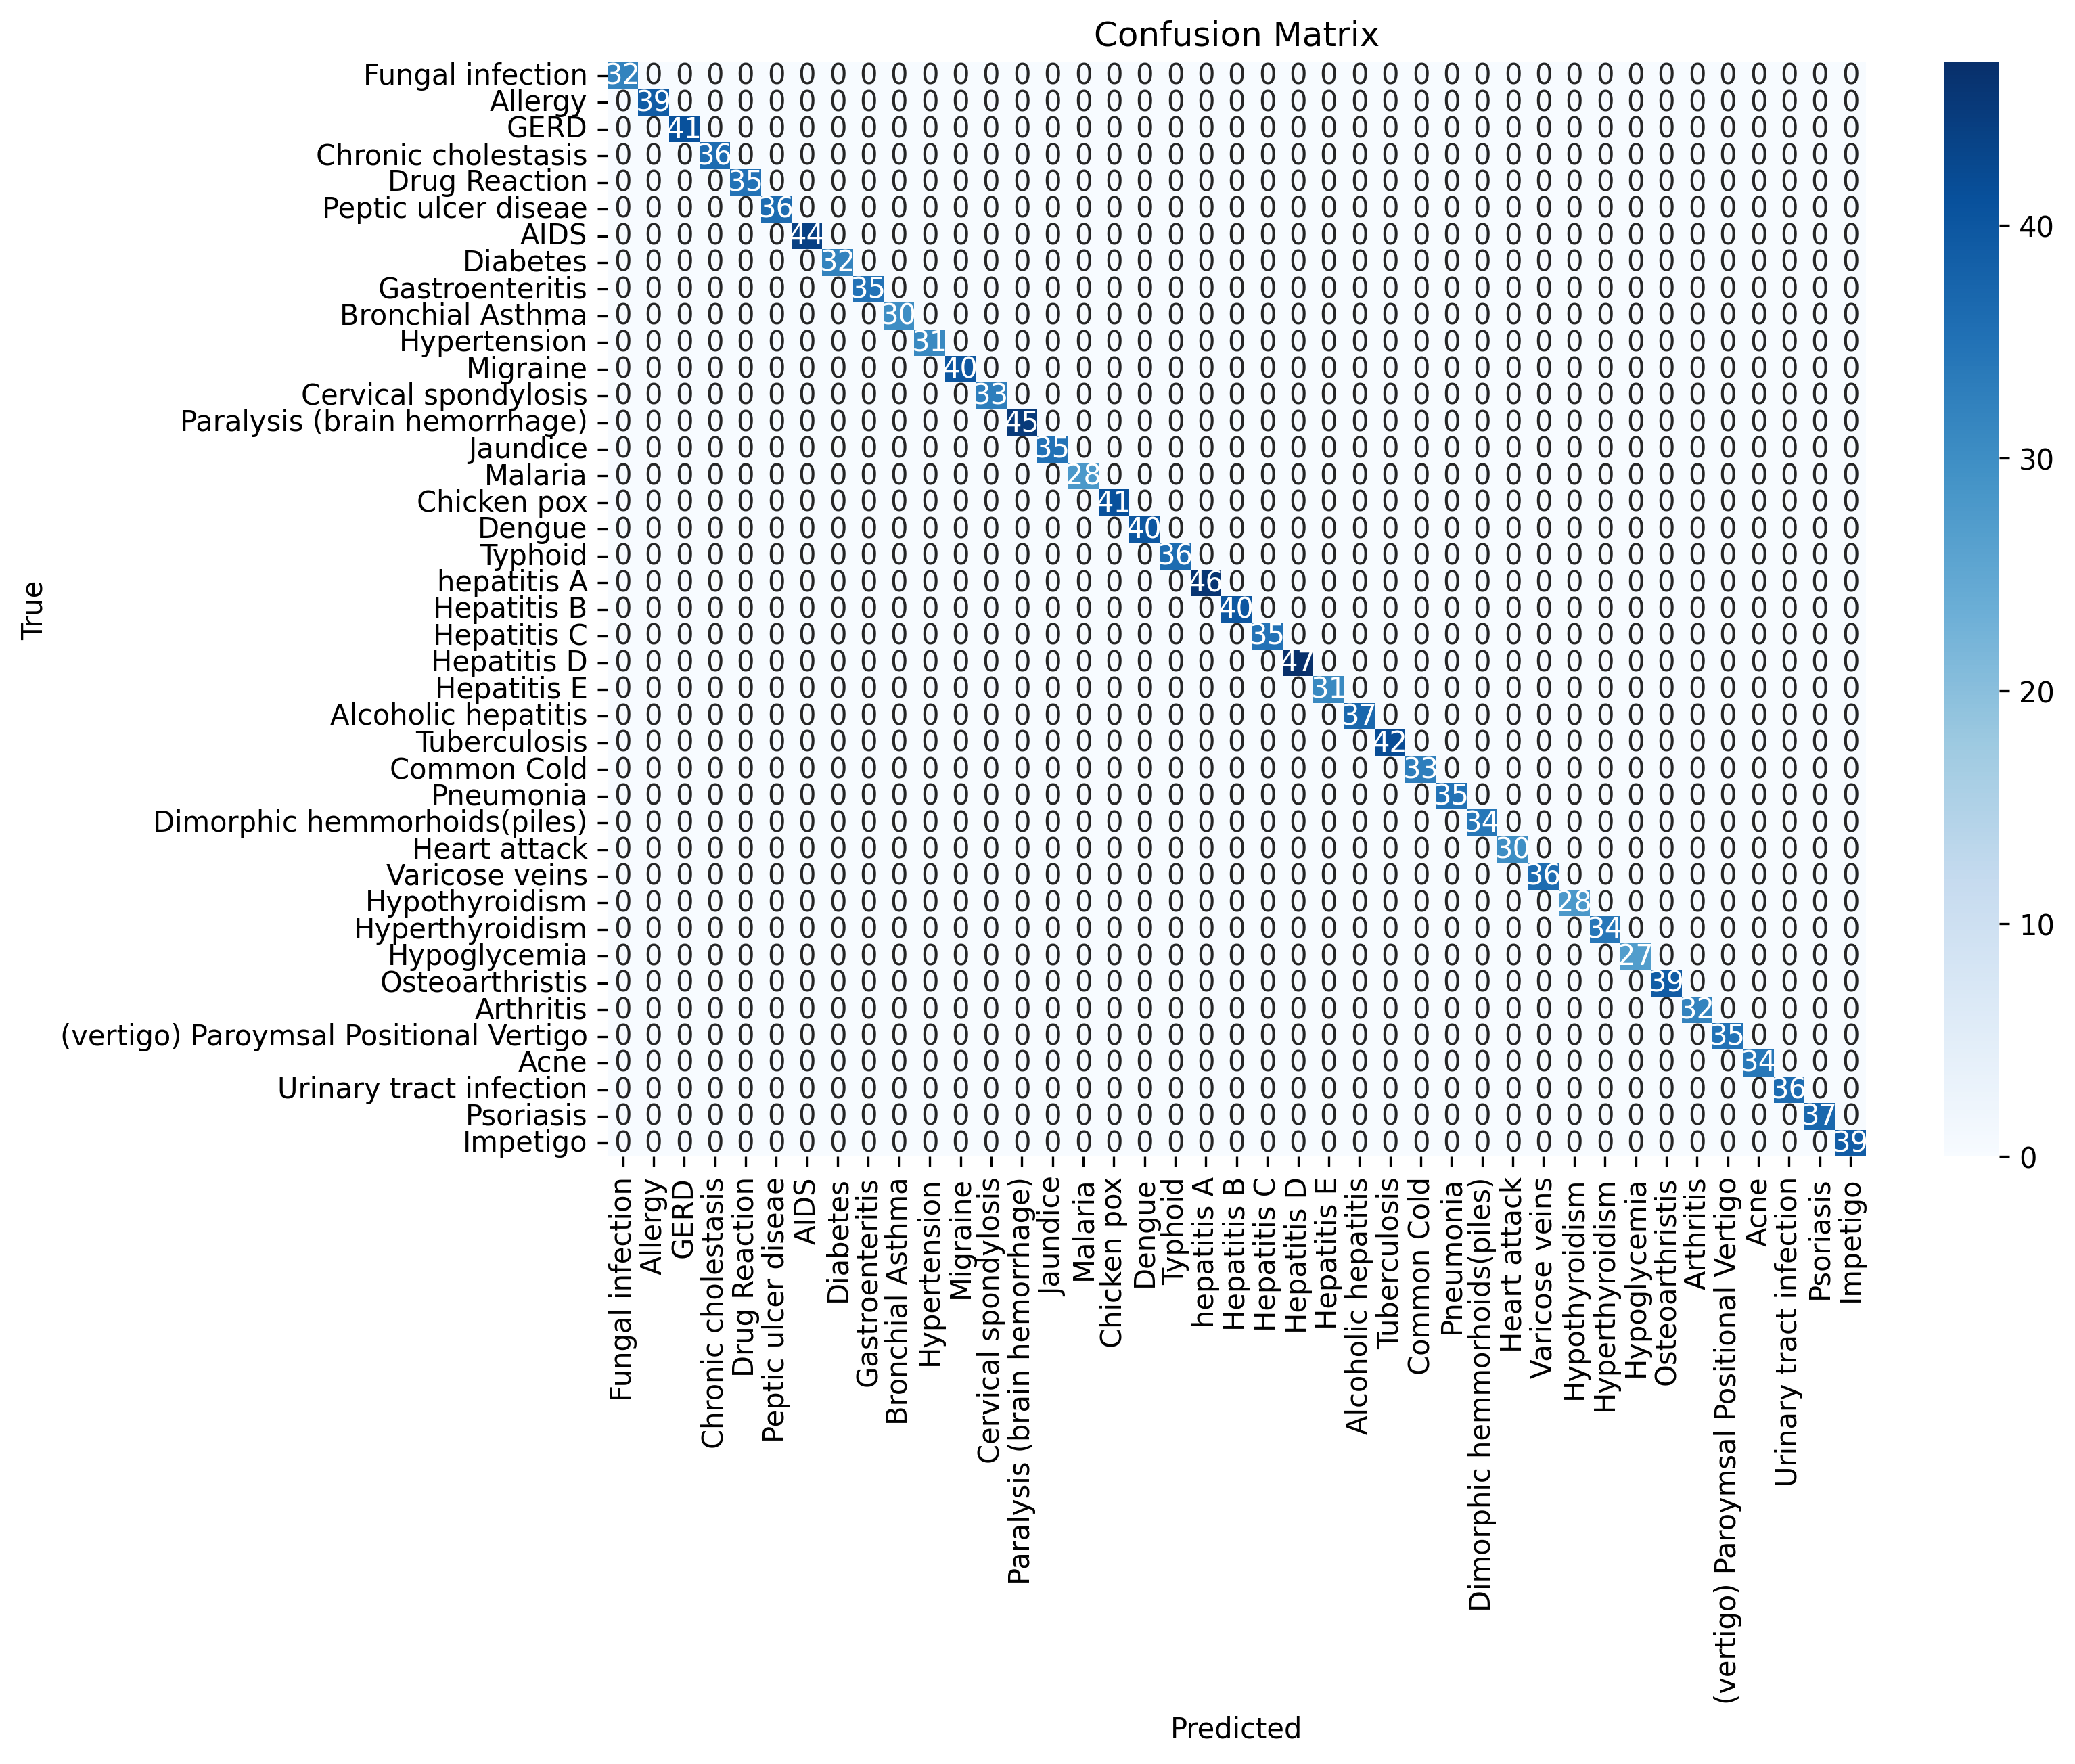

In [328]:
# Create confusion matrix
cm = confusion_matrix(y_test_bin, predictions)
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_binary.unique(), yticklabels=y_binary.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### **Random Forest**

In [329]:
param_grid = {'n_estimators': range(40, 46, 1),
              'max_depth' : range(12,15,1),
              'criterion' :['gini', 'entropy','log_loss'],
             }

model = RandomForestClassifier(random_state = 42)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, verbose=True)
grid_search.fit(X_train_bin, y_train_bin)

final_model = grid_search.best_estimator_
joblib.dump(final_model, './Models_Fulldata/random_forest_model.pkl')
print(final_model)

# Train
final_model.fit(X_train_bin, y_train_bin)

# Prediction
predictions = final_model.predict(X_test_bin)

# Evaluation
print(classification_report(y_test_bin, predictions))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
RandomForestClassifier(max_depth=14, n_estimators=40, random_state=42)
                                        precision    recall  f1-score   support

(vertigo) Paroymsal Positional Vertigo       1.00      1.00      1.00        32
                                  AIDS       1.00      1.00      1.00        39
                                  Acne       1.00      1.00      1.00        41
                   Alcoholic hepatitis       1.00      1.00      1.00        36
                               Allergy       1.00      1.00      1.00        35
                             Arthritis       1.00      1.00      1.00        36
                      Bronchial Asthma       1.00      1.00      1.00        44
                  Cervical spondylosis       1.00      1.00      1.00        32
                           Chicken pox       1.00      1.00      1.00        35
                   Chronic cholestasis       1.00      1.00      1

### **Logistic Regression**

In [330]:
# Define parameters for the SVM model
param_grid = {'tol' : [.001,0.02,.005,.01,.02],
              'C' : [0.1, 0.5, 1, 2, 5],
              'solver' :['lbfgs', 'newton-cg', 'sag', 'saga'],
             }

# Create a logistic regression model
model = LogisticRegression(random_state = 42)
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, verbose = True)
# Fit the model to the training data
grid_search.fit(X_train_bin, y_train_bin)

# Get the best model from grid search
final_model = grid_search.best_estimator_
#  Save the model
joblib.dump(final_model, './Models_Fulldata/logistic_regression_model.pkl')
# Print the best parameters
print(final_model)

# Train the final model on the training data
final_model.fit(X_train_bin, y_train_bin)

# Prediction on the test set
predictions = final_model.predict(X_test_bin)

# Evaluation
print(classification_report(y_test_bin, predictions))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
LogisticRegression(C=0.1, random_state=42, tol=0.001)
                                        precision    recall  f1-score   support

(vertigo) Paroymsal Positional Vertigo       1.00      1.00      1.00        32
                                  AIDS       1.00      1.00      1.00        39
                                  Acne       1.00      1.00      1.00        41
                   Alcoholic hepatitis       1.00      1.00      1.00        36
                               Allergy       1.00      1.00      1.00        35
                             Arthritis       1.00      1.00      1.00        36
                      Bronchial Asthma       1.00      1.00      1.00        44
                  Cervical spondylosis       1.00      1.00      1.00        32
                           Chicken pox       1.00      1.00      1.00        35
                   Chronic cholestasis       1.00      1.00      1.00        30
  

### **Support Vector Classifier**

In [331]:
# Define parameters for the Decision Tree model
param_grid = {'C' : [.01,.02,.05,0.1, .2],
              'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
              'degree' : [1,2,3,4],
             }

# Create a logistic regression model
model = SVC(random_state = 42)
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, verbose = True)
# Fit the model to the training data
grid_search.fit(X_train_bin, y_train_bin)

# Get the best model from grid search
final_model = grid_search.best_estimator_
# Save model
joblib.dump(final_model, './Models_Fulldata/support_vector_model.pkl')
# Print the best parameters
print(final_model)

# Train the final model on the training data
final_model.fit(X_train_bin, y_train_bin)
# Prediction on the test set
predictions = final_model.predict(X_test_bin)

# Evaluation
print(classification_report(y_test_bin, predictions))

Fitting 5 folds for each of 80 candidates, totalling 400 fits
SVC(C=0.01, degree=1, kernel='linear', random_state=42)
                                        precision    recall  f1-score   support

(vertigo) Paroymsal Positional Vertigo       1.00      1.00      1.00        32
                                  AIDS       1.00      1.00      1.00        39
                                  Acne       1.00      1.00      1.00        41
                   Alcoholic hepatitis       1.00      1.00      1.00        36
                               Allergy       1.00      1.00      1.00        35
                             Arthritis       1.00      1.00      1.00        36
                      Bronchial Asthma       1.00      1.00      1.00        44
                  Cervical spondylosis       1.00      1.00      1.00        32
                           Chicken pox       1.00      1.00      1.00        35
                   Chronic cholestasis       1.00      1.00      1.00        30
 

### **K-Nearest Neighbors**

In [332]:
# Define parameters for the KNN model
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [20, 30, 40, 50],
}

# Create a K-nearest neighbors model
model = KNeighborsClassifier()

# Create a grid search object
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, verbose = True)
# Perform grid search using the training data
grid_search.fit(X_train_bin, y_train_bin)
# Get the best model from grid search
final_model = grid_search.best_estimator_

# Save model
joblib.dump(final_model, './Models_Fulldata/k_nearest_neighbors_model.pkl')
# Print the best model
print(final_model)

# Train the best model
final_model.fit(X_train_bin, y_train_bin)
# Evaluate the best model
predictions = final_model.predict(X_test_bin)

# Evaluation
print(classification_report(y_test_bin, predictions))

Fitting 5 folds for each of 80 candidates, totalling 400 fits
KNeighborsClassifier(leaf_size=20, n_neighbors=3)
                                        precision    recall  f1-score   support

(vertigo) Paroymsal Positional Vertigo       1.00      1.00      1.00        32
                                  AIDS       1.00      1.00      1.00        39
                                  Acne       1.00      1.00      1.00        41
                   Alcoholic hepatitis       1.00      1.00      1.00        36
                               Allergy       1.00      1.00      1.00        35
                             Arthritis       1.00      1.00      1.00        36
                      Bronchial Asthma       1.00      1.00      1.00        44
                  Cervical spondylosis       1.00      1.00      1.00        32
                           Chicken pox       1.00      1.00      1.00        35
                   Chronic cholestasis       1.00      1.00      1.00        30
       

### **Neural Network**

Best params: {'activation': 'relu', 'batch_size': 16, 'dropout': 0.2, 'epochs': 50, 'l2_reg': 0.001, 'layer1': 64, 'layer2': 16}

In [ ]:
# Prepare data for Keras network
X_train_nn = X_train_bin.values
X_test_nn  = X_test_bin.values

y_train_nn = LabelEncoder().fit_transform(y_train_bin)
y_test_nn = LabelEncoder().fit_transform(y_test_bin)

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1606 - loss: 3.5499 - val_accuracy: 0.7379 - val_loss: 2.2323
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.7249 - loss: 1.8891 - val_accuracy: 0.9942 - val_loss: 0.6468
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.9361 - loss: 0.7376 - val_accuracy: 1.0000 - val_loss: 0.3264
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.9641 - loss: 0.4874 - val_accuracy: 1.0000 - val_loss: 0.2728
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.9658 - loss: 0.4062 - val_accuracy: 1.0000 - val_loss: 0.2564
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.9778 - loss: 0.3872 - val_accuracy: 1.0000 - val_loss: 0.2467
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.9716 - loss: 0.3704 - val_accuracy: 1.0000 - val_loss: 0.2385
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.9744 - loss: 0.3506 - va

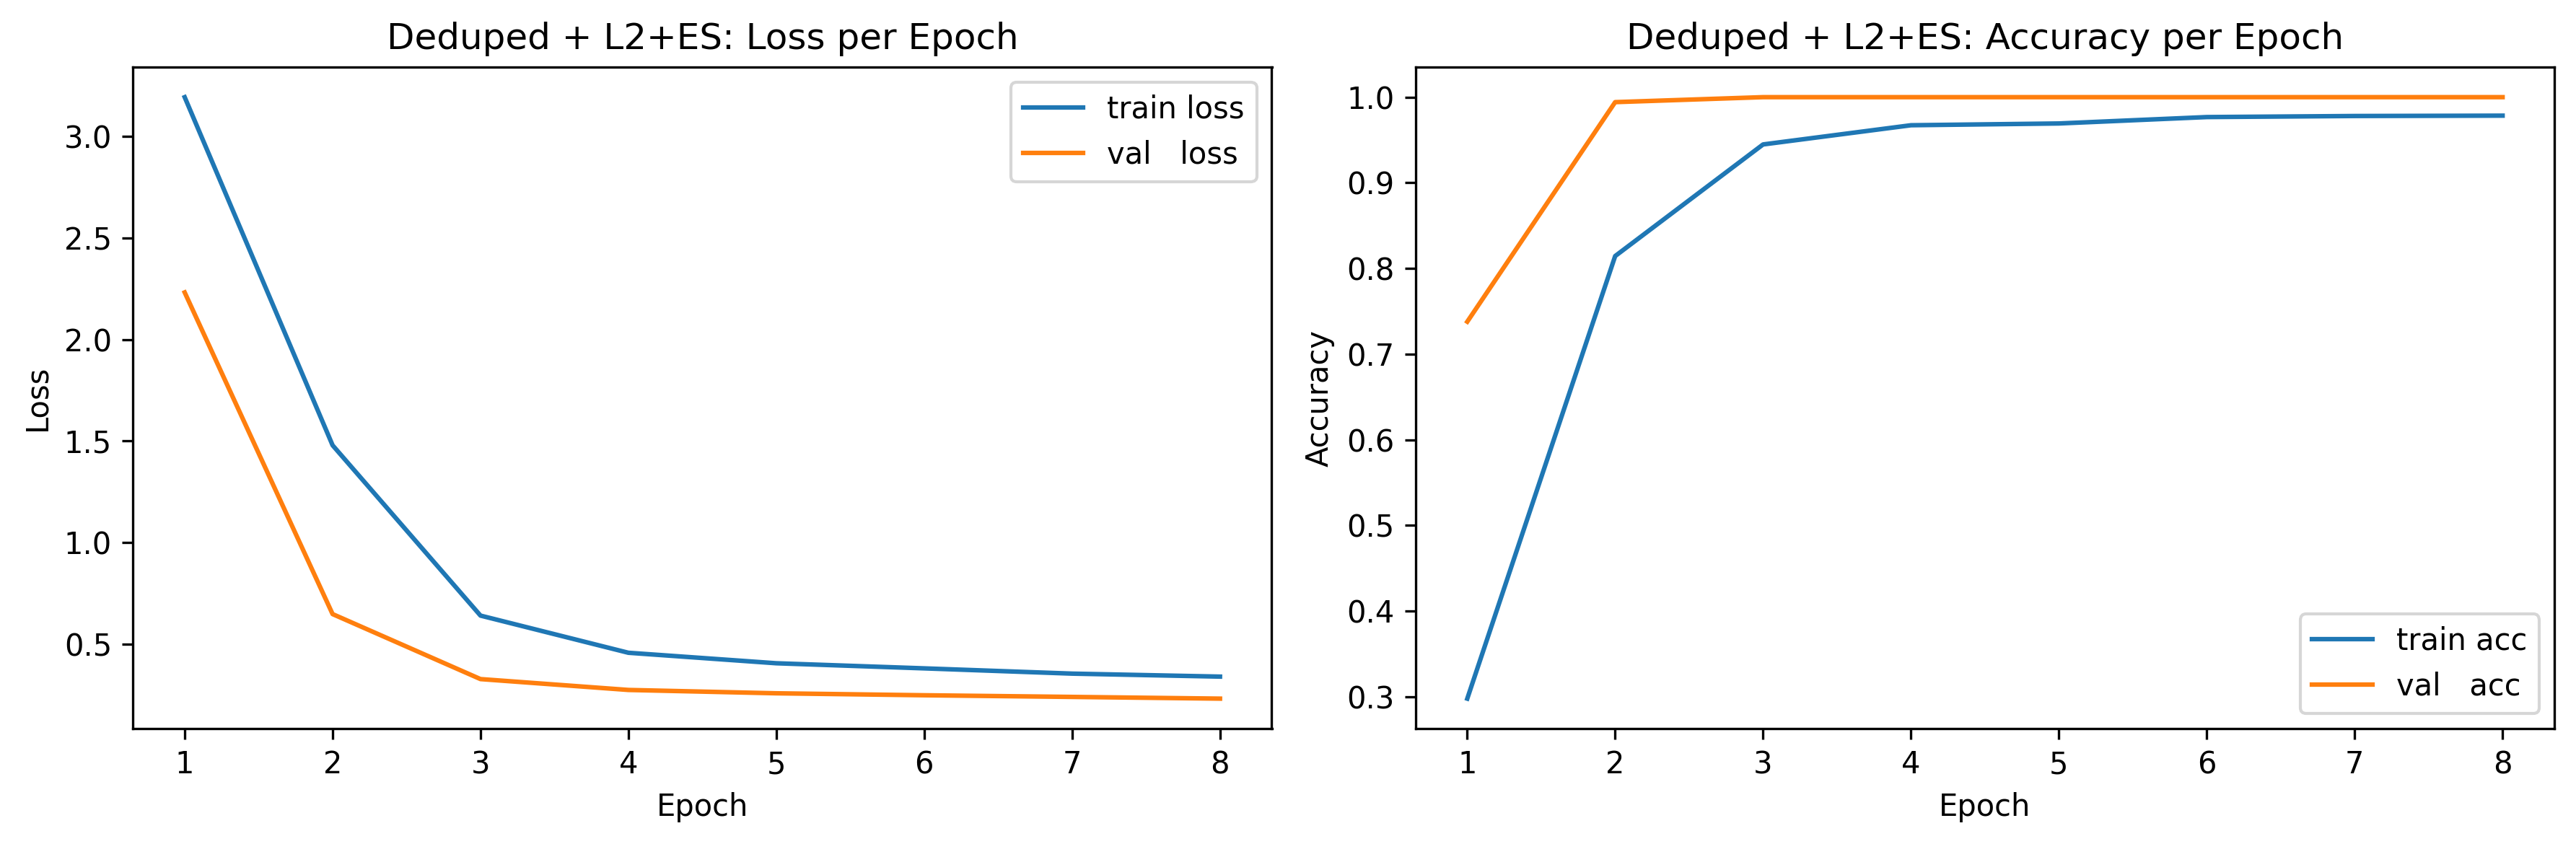

L2 + EarlyStopping: Test loss: 0.3269,  Test accuracy: 1.0000


In [459]:
# Define neural network with previously-found optimal parameters

model_nn = Sequential([
    Input(shape=(X_train_nn.shape[1], )),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense( len(np.unique(y_train_nn)) , activation='softmax')
])

model_nn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping callback (same patience)
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# Train with L2 + EarlyStopping
history_nn = model_nn.fit(
    X_train_nn, 
    y_train_nn,
    validation_split=0.30,
    # validation_data=(X_test_nn, y_test_nn),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# Plot Loss & Accuracy
epochs_l2 = len(history_nn.history['loss'])
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(range(1, epochs_l2+1), history_nn.history['loss'],    label='train loss')
plt.plot(range(1, epochs_l2+1), history_nn.history['val_loss'],label='val   loss')
plt.title('Deduped + L2+ES: Loss per Epoch')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs_l2+1), history_nn.history['accuracy'],    label='train acc')
plt.plot(range(1, epochs_l2+1), history_nn.history['val_accuracy'],label='val   acc')
plt.title('Deduped + L2+ES: Accuracy per Epoch')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout()
plt.show()

# Save model
model_nn.save('./Models_Fulldata/neural_net_model.keras')

# Evaluate on test subset
loss_nn, acc_nn = model_nn.evaluate(X_test_nn, y_test_nn, verbose=0)
print(f"L2 + EarlyStopping: Test loss: {loss_nn:.4f},  Test accuracy: {acc_nn:.4f}")

### **Model Accuracy on Corrupted Data**

In [333]:
# Get all scikit-learn models in the Models_Fulldata directory

# Create a list to hold the models
models = []

for model_name in os.listdir('./Models_Fulldata'):
    # Check if the file is a .pkl file
    if model_name.endswith('.pkl'):
        # Load the model using joblib
        model = joblib.load('./Models_Fulldata/' + model_name)
        # Append the model to the list
        models.append(model)

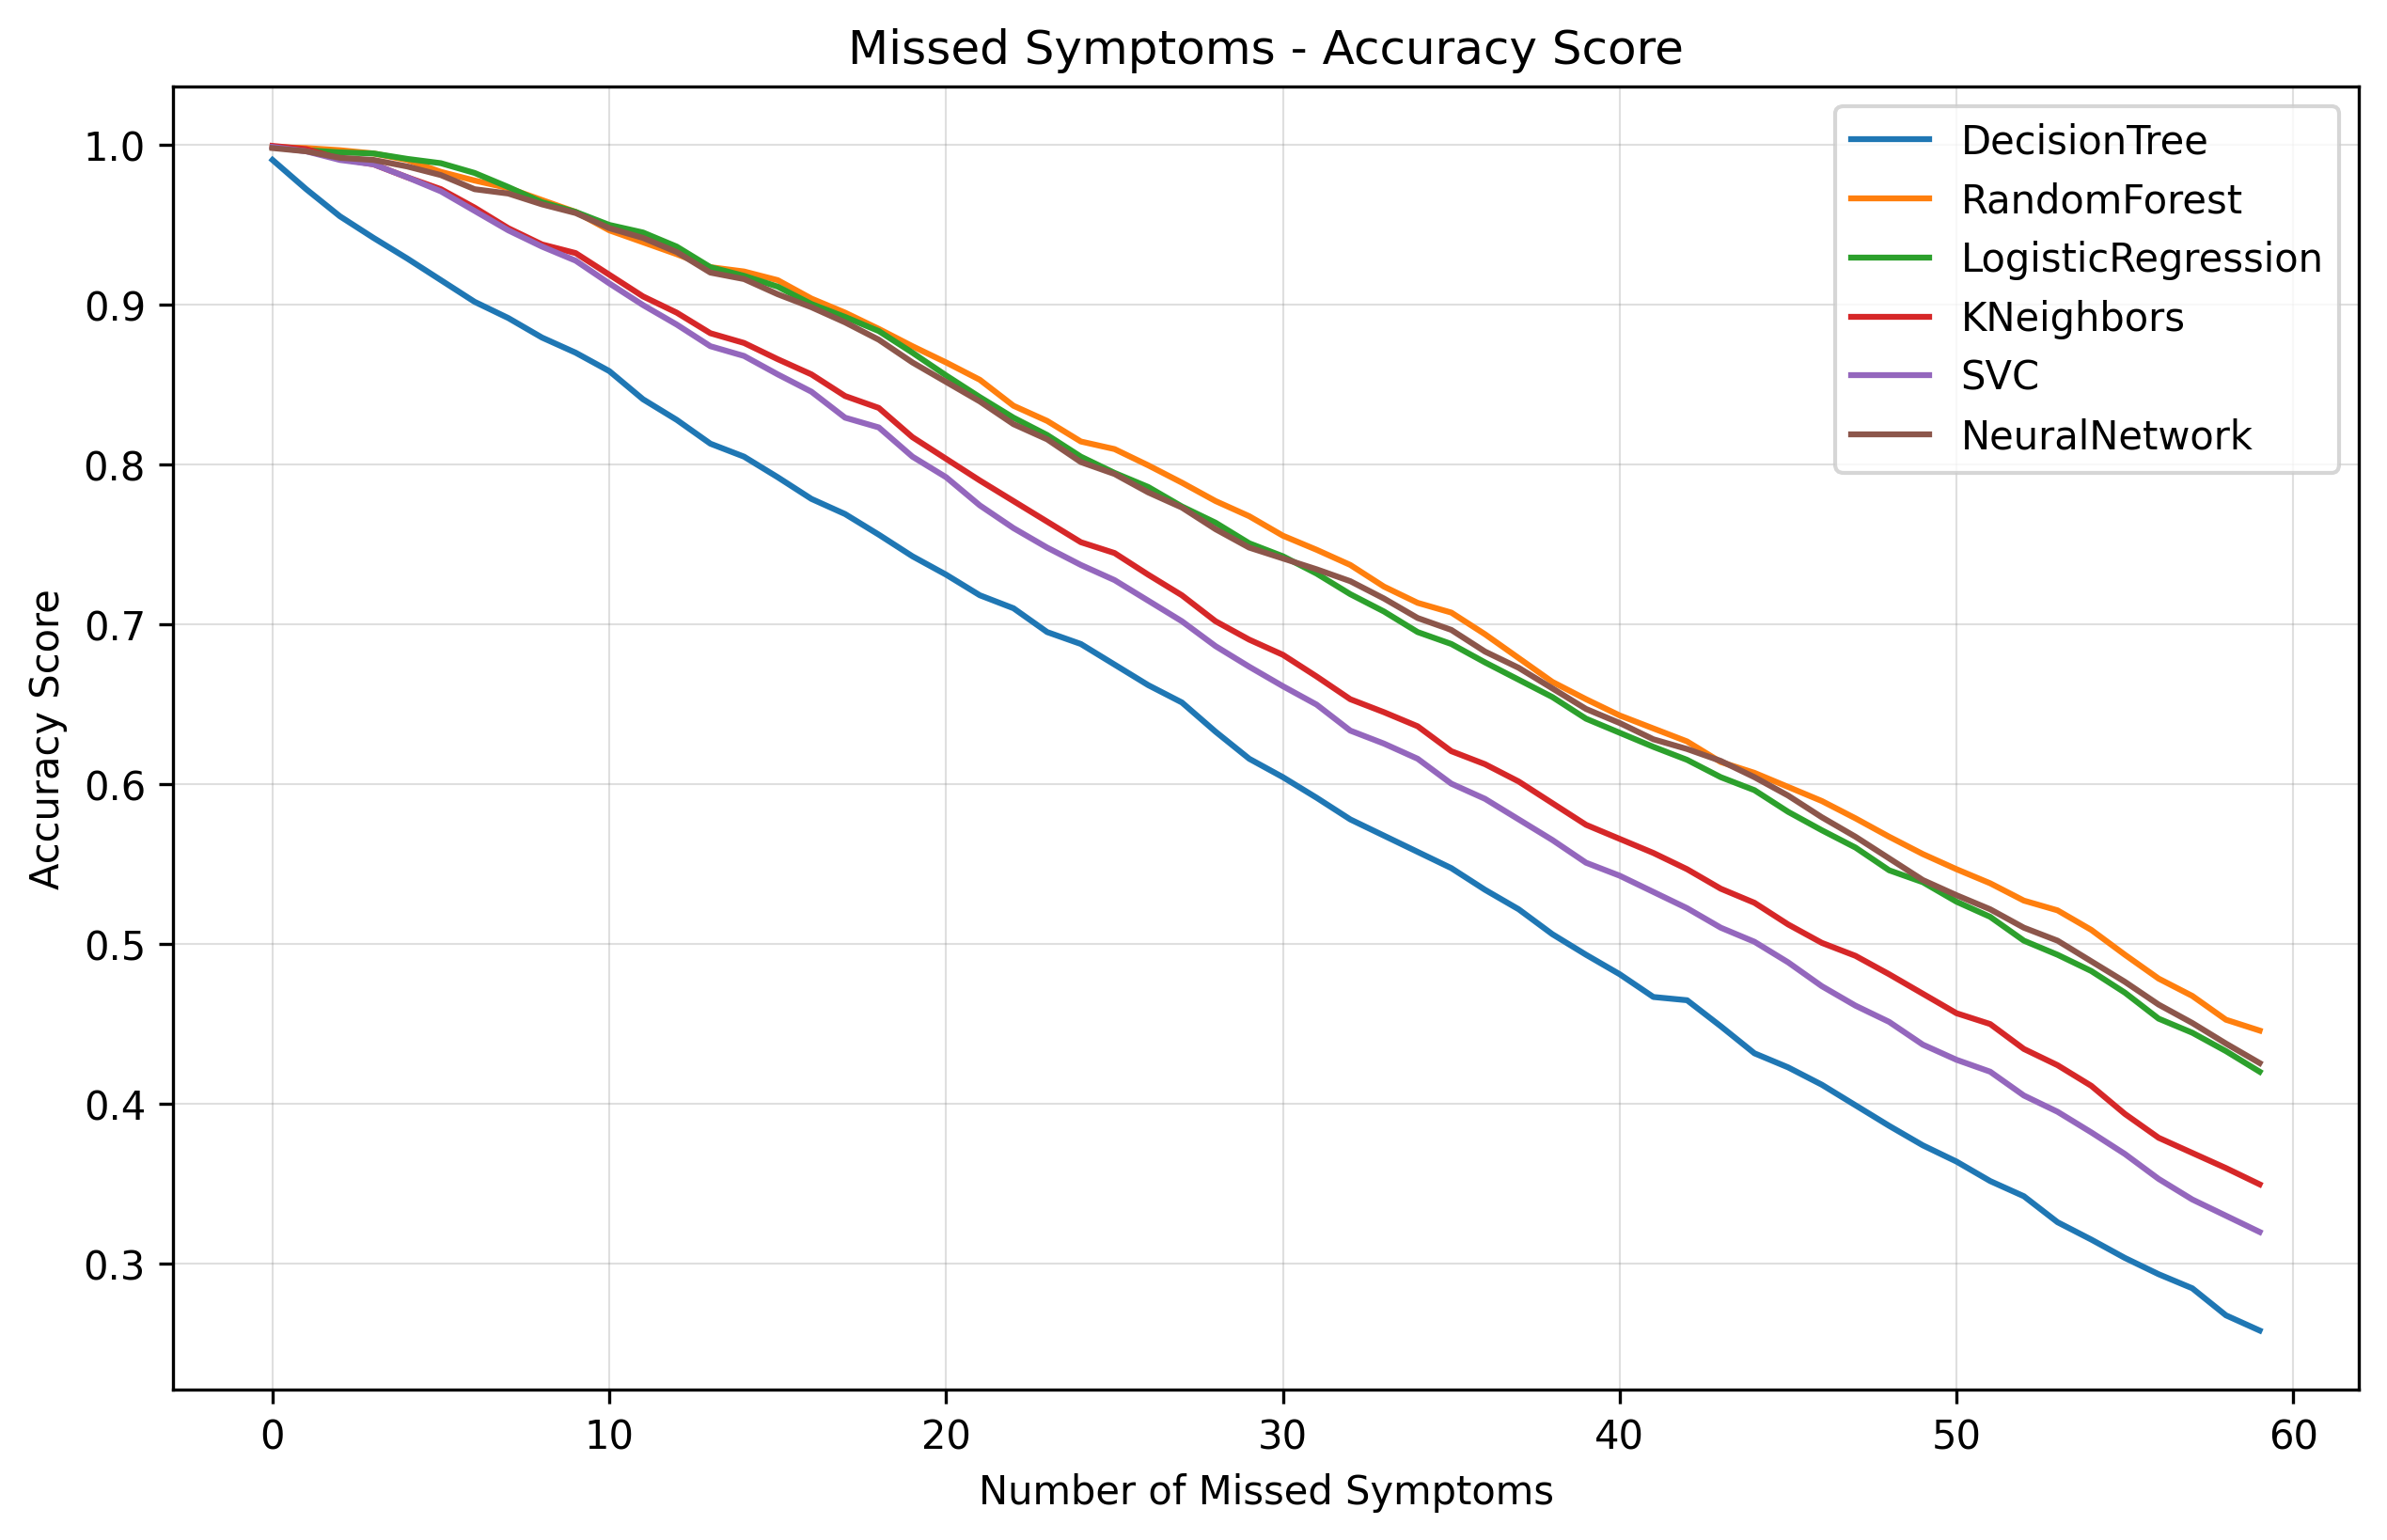

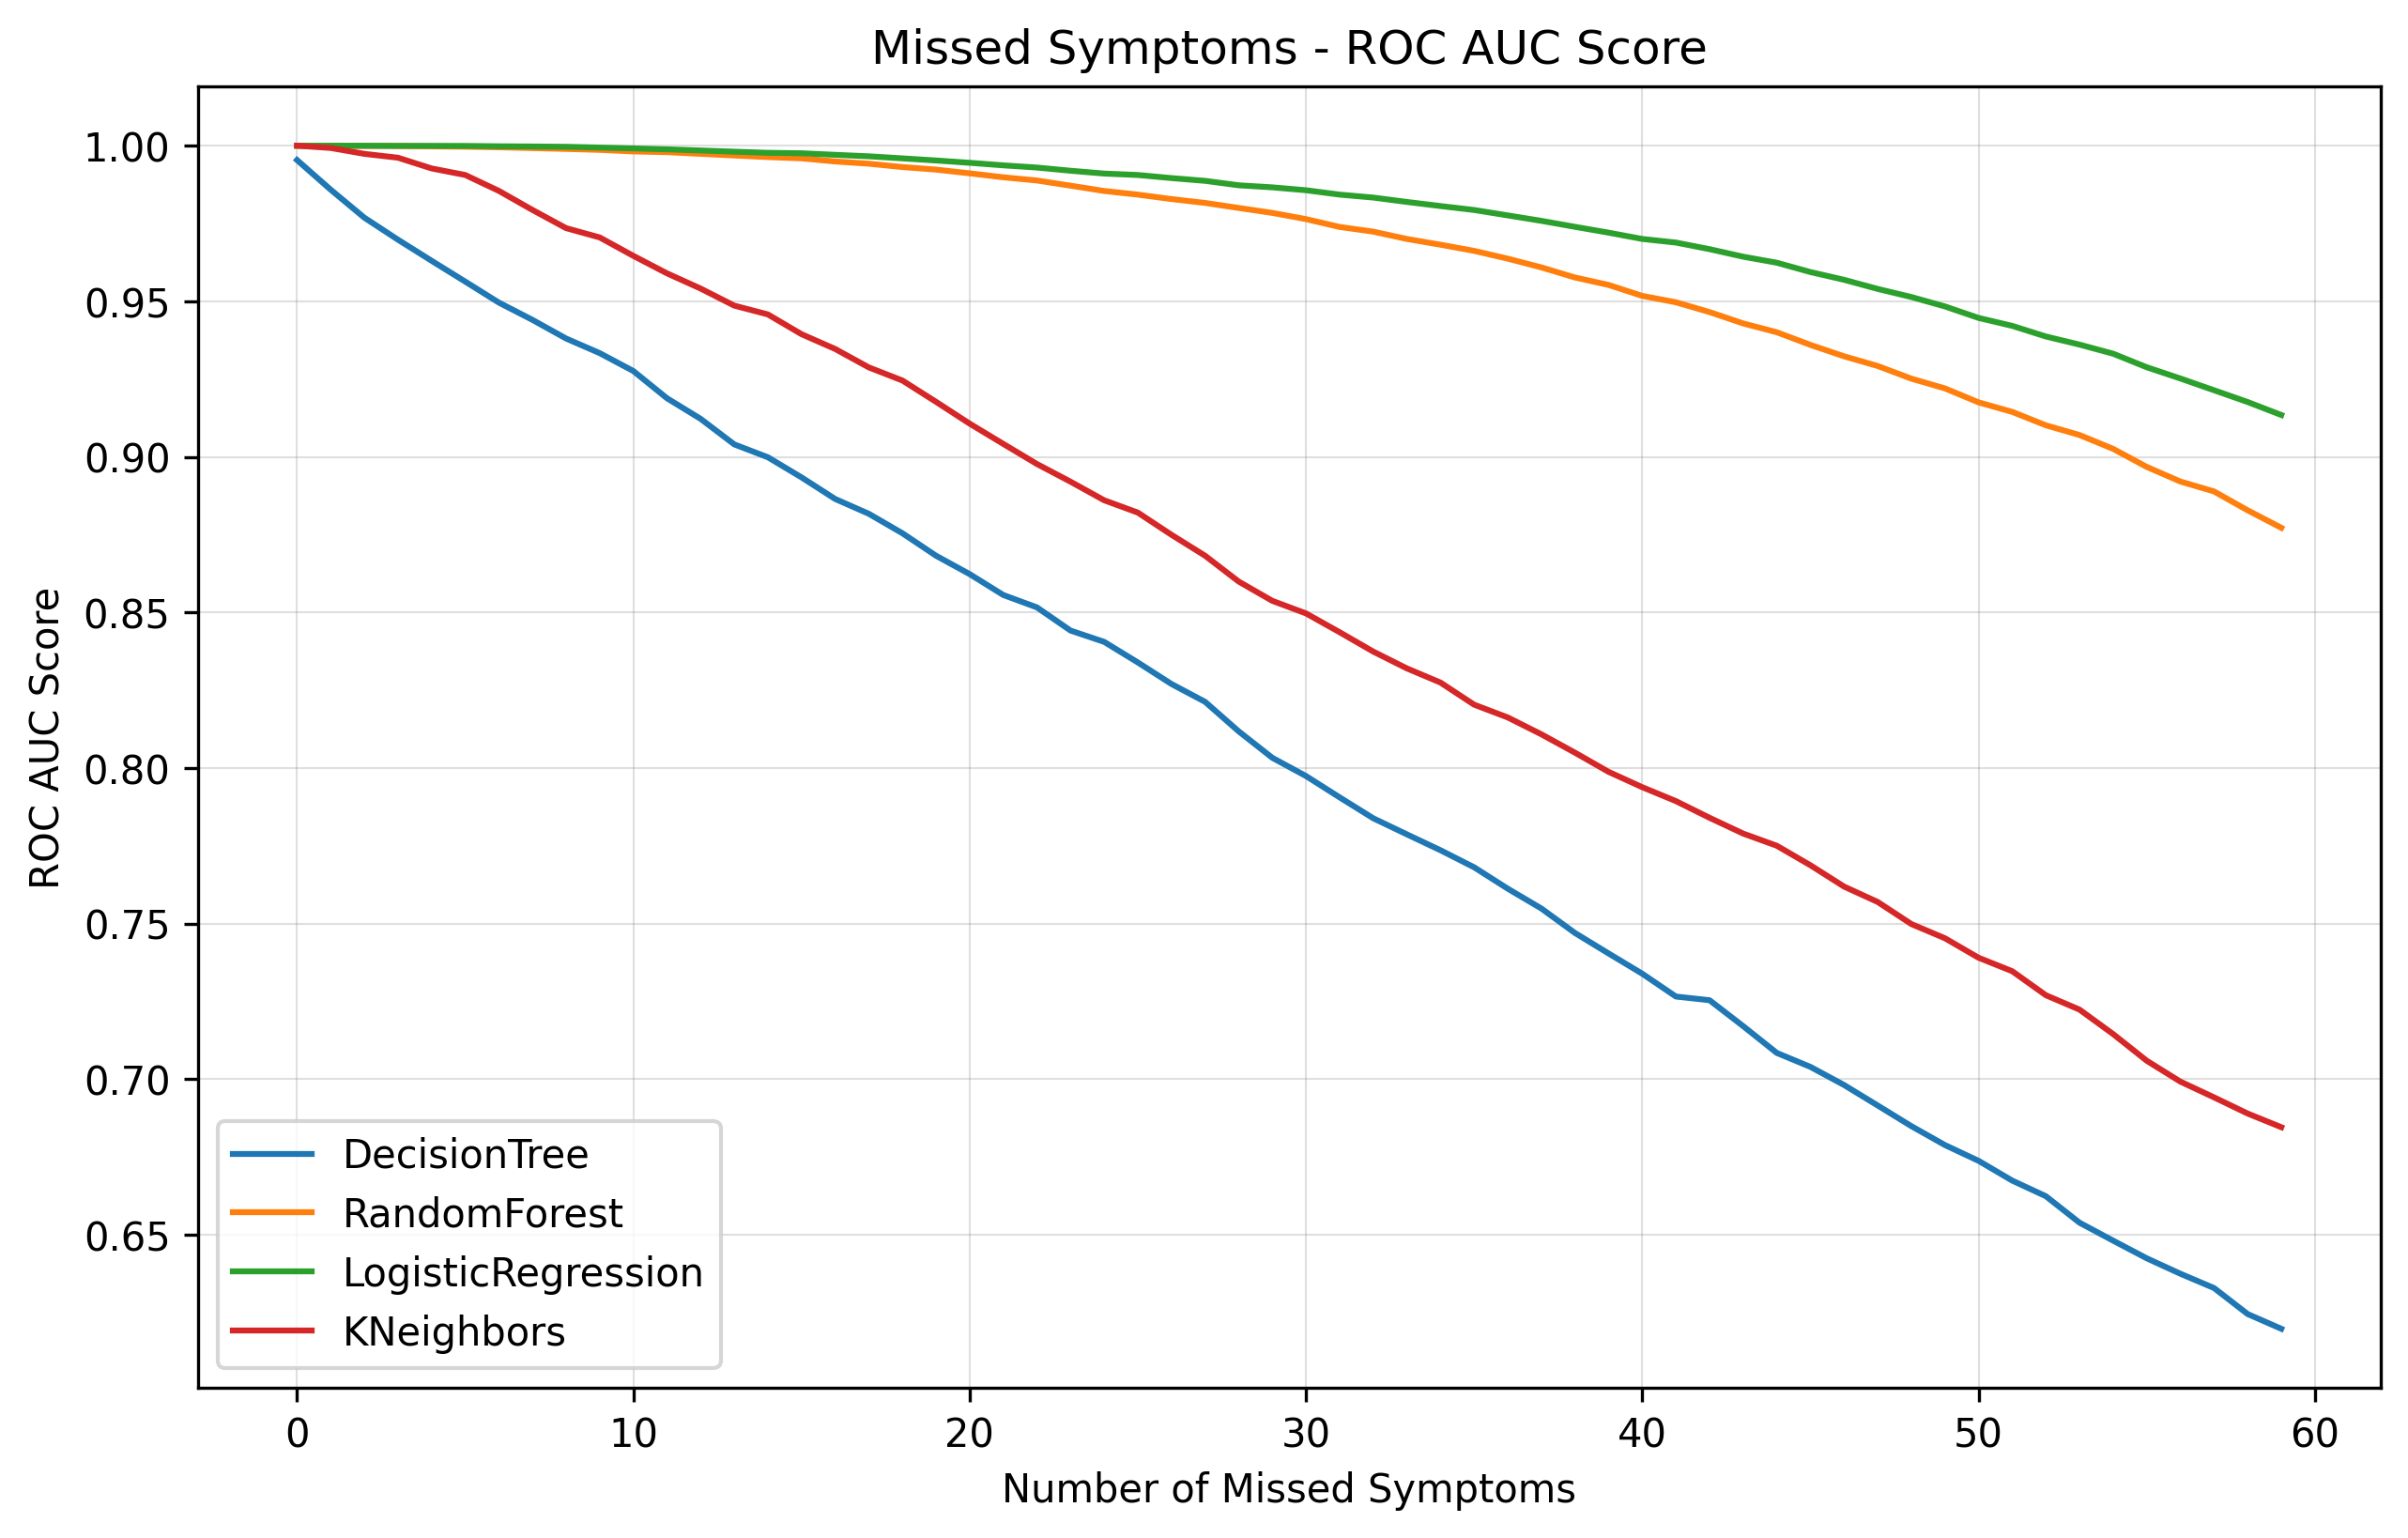

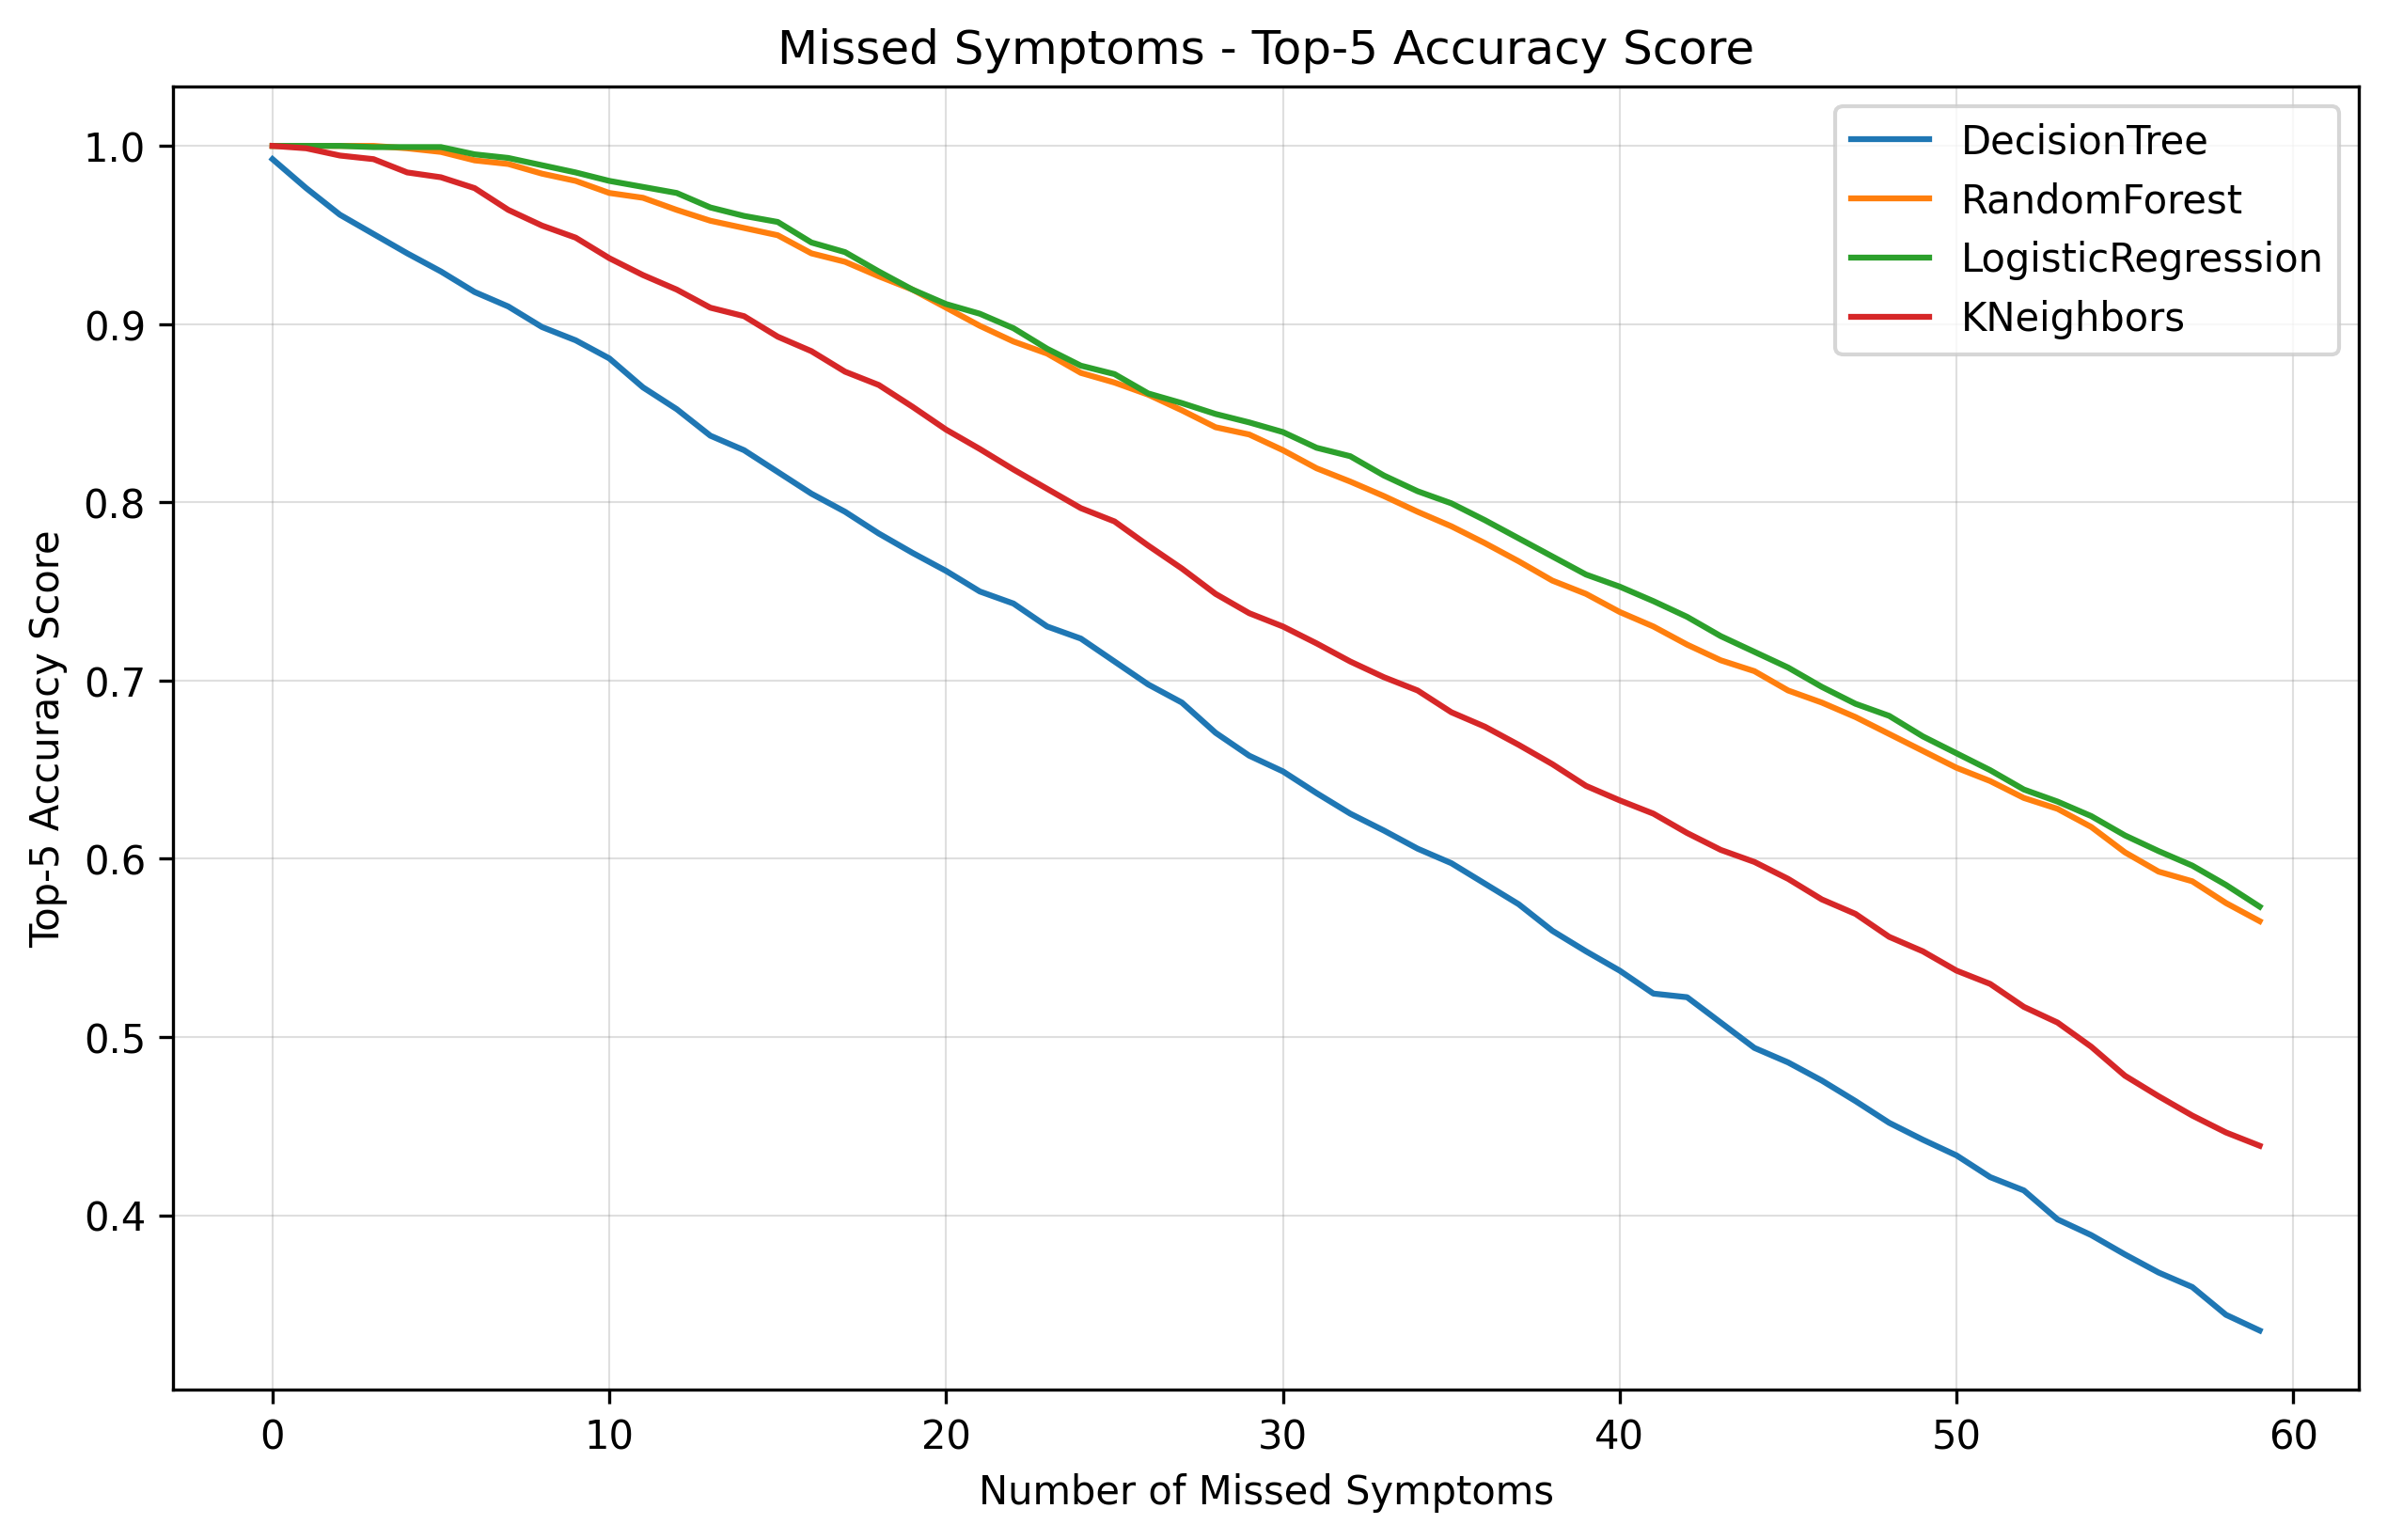

In [466]:
# Redefine binary dataframes
X_sub = binary.drop(columns=['Disease'])
y_sub = binary['Disease']

# Split the data into training and testing sets (70% train, 30% test)
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size = 0.3, train_size = 0.7, random_state = 42)

# Define maximum number of added symptoms
max_missed_symptoms = 60

# Define array for accuracies
accs = np.empty((len(models), max_missed_symptoms))
rocs = np.empty((len(models), max_missed_symptoms))
topk = np.empty((len(models), max_missed_symptoms))

acc_nn = []

# Iterate over each unique symptom
# for i in range(len(unique_symptoms)):
for i in range(max_missed_symptoms):

    # Get indices where the symptom is not present
    # index, columns = np.where(X_test_sub == 0)
    # Choose a random symptom index from the columns where the value is 1
    # random_symptom_index = np.random.choice(columns)
    # Set the random symptom to 1 (present)
    # X_test_sub.iloc[:, random_symptom_index] = 1

    for _ in range(len(unique_symptoms)):

        index, columns = np.where(X_test_sub == 1)  # Get indices where the symptom is not present
        random_patient = np.random.choice(index)

        X_test_sub.iloc[index[random_patient], columns[random_patient]] = 0

    # Compute accuracies
    for j in range(len(models)):

        # Predict using the model
        predictions = models[j].predict(X_test_sub)
        # Evaluate the model
        accuracy = accuracy_score(y_test_sub, predictions)
        # Save the accuracy in the array
        accs[j, i] = accuracy

    # Compute ROC AUC and Top-K accuracy for each model (except SVC)  
    for j, model in enumerate(models):
        if model.__class__.__name__ != 'SVC': 
            y_scores = models[j].predict_proba(X_test_sub)
            roc_auc = roc_auc_score(y_test_sub, y_scores, multi_class='ovr', average='macro')
            rocs[j, i] = roc_auc

            topk_accuracy = top_k_accuracy_score(y_test_sub, y_scores, k=5)
            topk[j, i] = topk_accuracy

    # Compute predictions from neural network
    _, accuracy_nn = model_nn.evaluate(X_test_sub.values, LabelEncoder().fit_transform(y_test_sub), verbose = -1)
    # Append accuracy
    acc_nn.append(accuracy_nn)

# Setup figure size
plt.figure(figsize=(10, 6))

# Plot the accuracies
for k, model in enumerate(models):
    # Plot the accuracies for each model
    plt.plot(accs[k, :], label=model.__class__.__name__.split('Classifier')[0])
# Plot neural network accuracy
plt.plot(acc_nn, label = "NeuralNetwork")

# Accuracy plot
plt.title('Missed Symptoms - Accuracy Score')
plt.xlabel('Number of Missed Symptoms')
plt.ylabel('Accuracy Score')
# plt.ylim(0, 1)
plt.grid(visible = True, color = 'grey', alpha = 0.25, linewidth = 0.5)
plt.legend()
# Save figure
plt.savefig('./Plots/Classifier_Fulldata/missed_accuracy.pdf')
# Show plot
plt.show()

# Setup figure size
plt.figure(figsize=(10, 6))

# Plot the ROC AUC scores
for k, model in enumerate(models):
    # Plot the accuracies for each model (ignore SVC)
    if model.__class__.__name__ != 'SVC':
        plt.plot(rocs[k, :], label=model.__class__.__name__.split('Classifier')[0])

# ROC plot
plt.title('Missed Symptoms - ROC AUC Score')
plt.xlabel('Number of Missed Symptoms')
plt.ylabel('ROC AUC Score')
# plt.ylim(0, 1)
plt.grid(visible = True, color = 'grey', alpha = 0.25, linewidth = 0.5)
plt.legend()
# Save figure
plt.savefig('./Plots/Classifier_Fulldata/missed_roc.pdf')
# Show plot
plt.show()

# Setup figure size
plt.figure(figsize=(10, 6))

# Plot the Top-K scores
for k, model in enumerate(models):
    # Plot the accuracies for each model (ignore SVC)
    if model.__class__.__name__ != 'SVC':
        plt.plot(topk[k, :], label=model.__class__.__name__.split('Classifier')[0])

# Top-K plot
plt.title('Missed Symptoms - Top-5 Accuracy Score')
plt.xlabel('Number of Missed Symptoms')
plt.ylabel('Top-5 Accuracy Score')
# plt.ylim(0, 1.)
plt.grid(visible = True, color = 'grey', alpha = 0.25, linewidth = 0.5)
plt.legend()
# Save figure
plt.savefig('./Plots/Classifier_Fulldata/missed_topk.pdf')
# Show plot
plt.show()

In [465]:
predictions_nn = model_nn.predict(X_test_sub.values)
predictions_nn

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


array([[5.00563206e-03, 1.81497924e-03, 6.18315876e-01, ...,
        1.09774631e-03, 1.84363991e-04, 8.13353574e-04],
       [2.00456078e-03, 4.76864952e-04, 7.99839795e-01, ...,
        2.60123634e-04, 2.62576305e-05, 1.57596427e-04],
       [6.57309738e-06, 7.43407727e-05, 3.51459926e-06, ...,
        1.52502470e-02, 1.10178180e-02, 1.77504015e-04],
       ...,
       [5.67338748e-06, 2.92636173e-06, 4.06099949e-04, ...,
        3.06462869e-04, 1.73513763e-05, 1.07603104e-04],
       [1.08832910e-05, 3.47211028e-07, 6.23396481e-05, ...,
        9.40351185e-07, 7.40574464e-08, 1.80527636e-07],
       [3.92961084e-07, 6.90160448e-07, 3.25950416e-04, ...,
        2.78446322e-07, 3.98888851e-08, 2.64838804e-03]], dtype=float32)

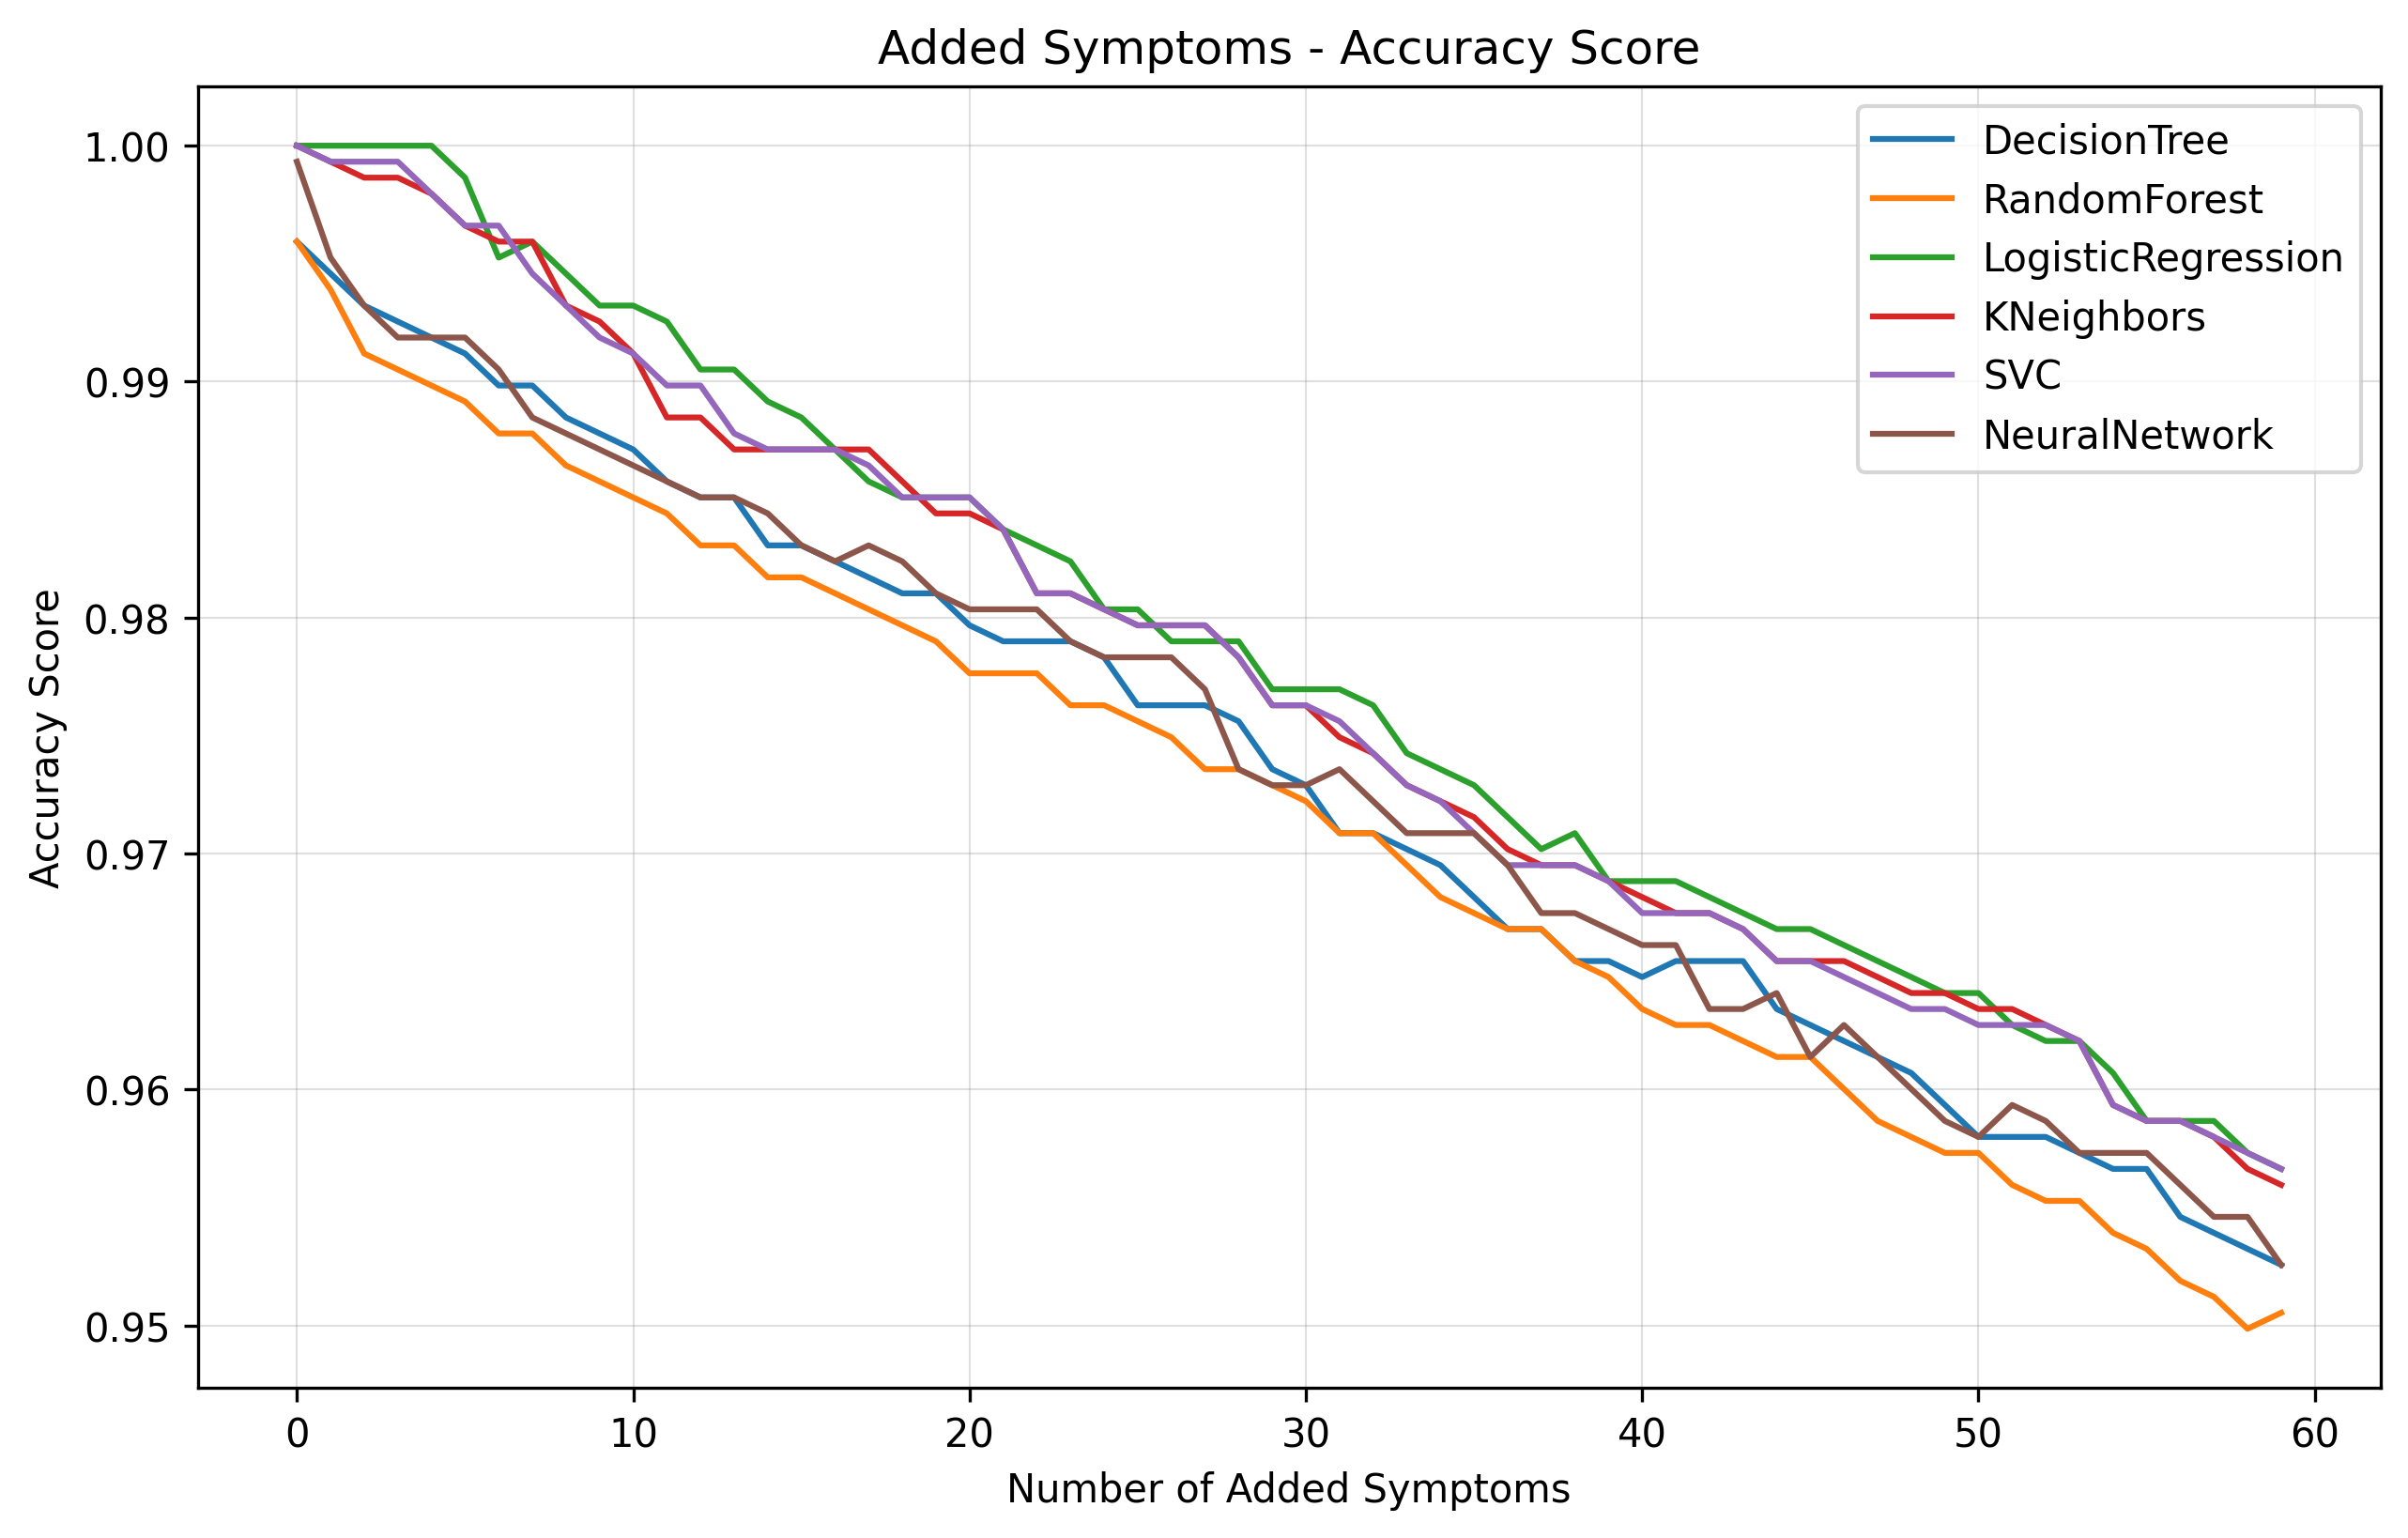

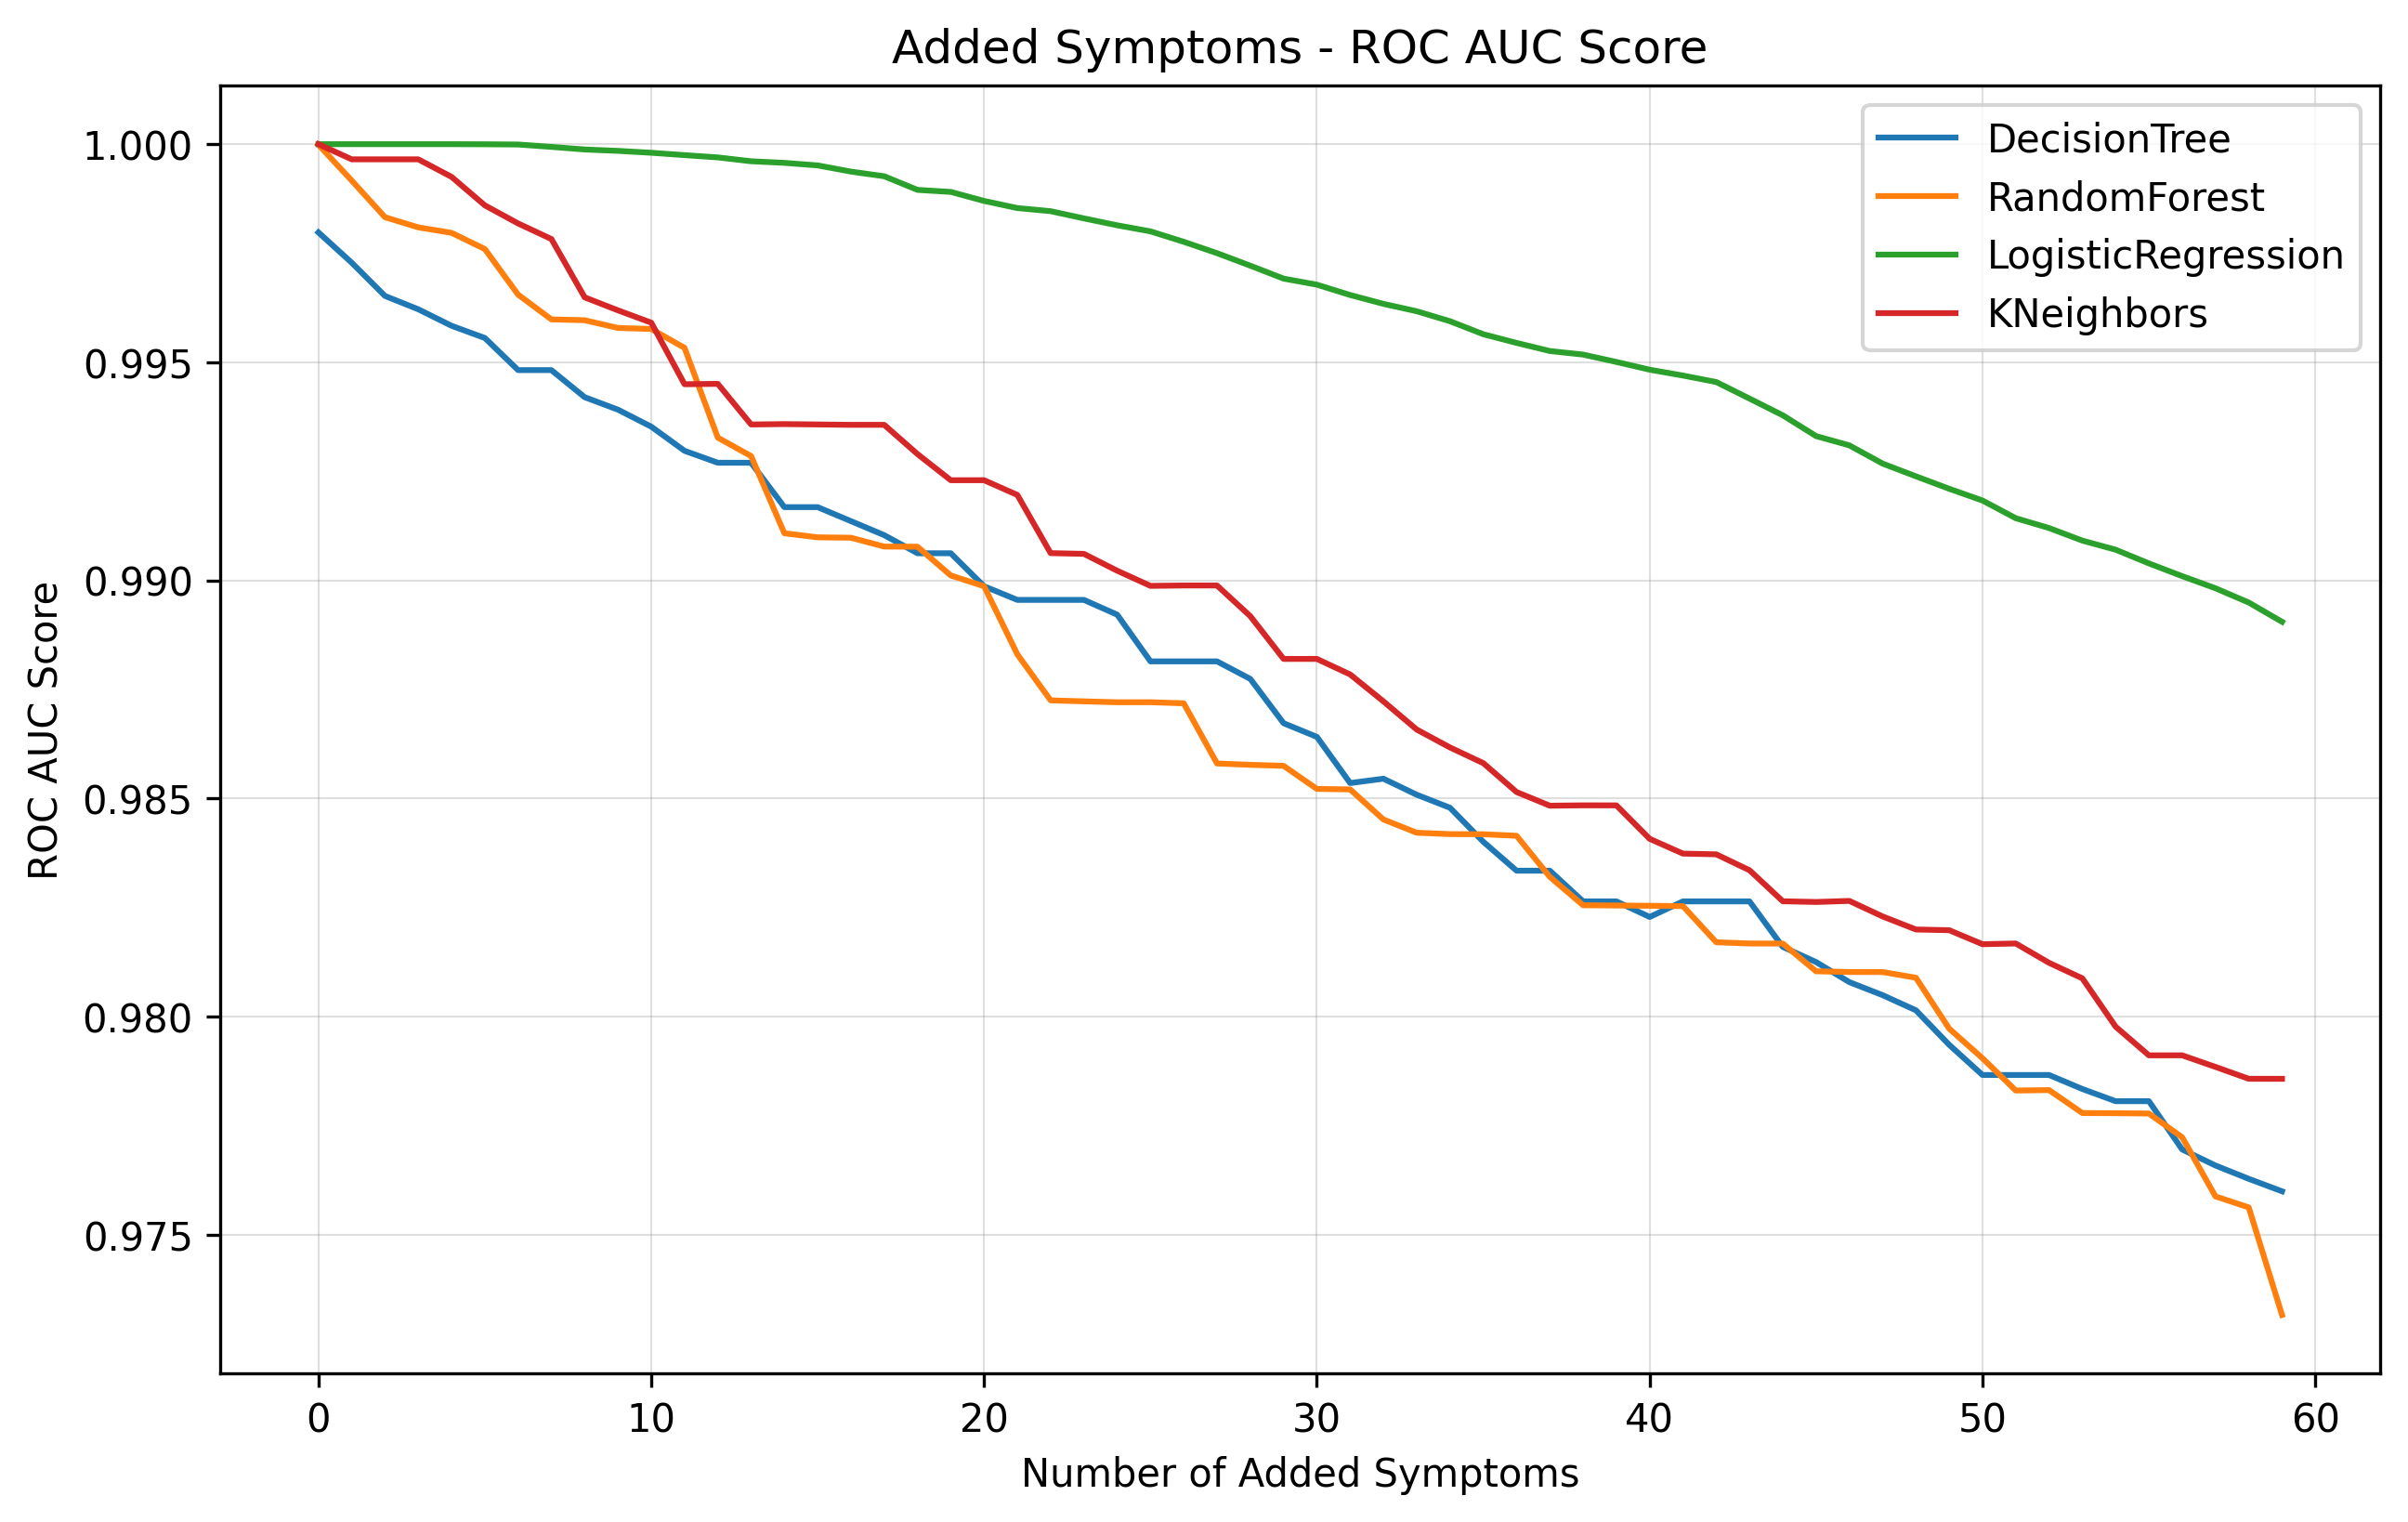

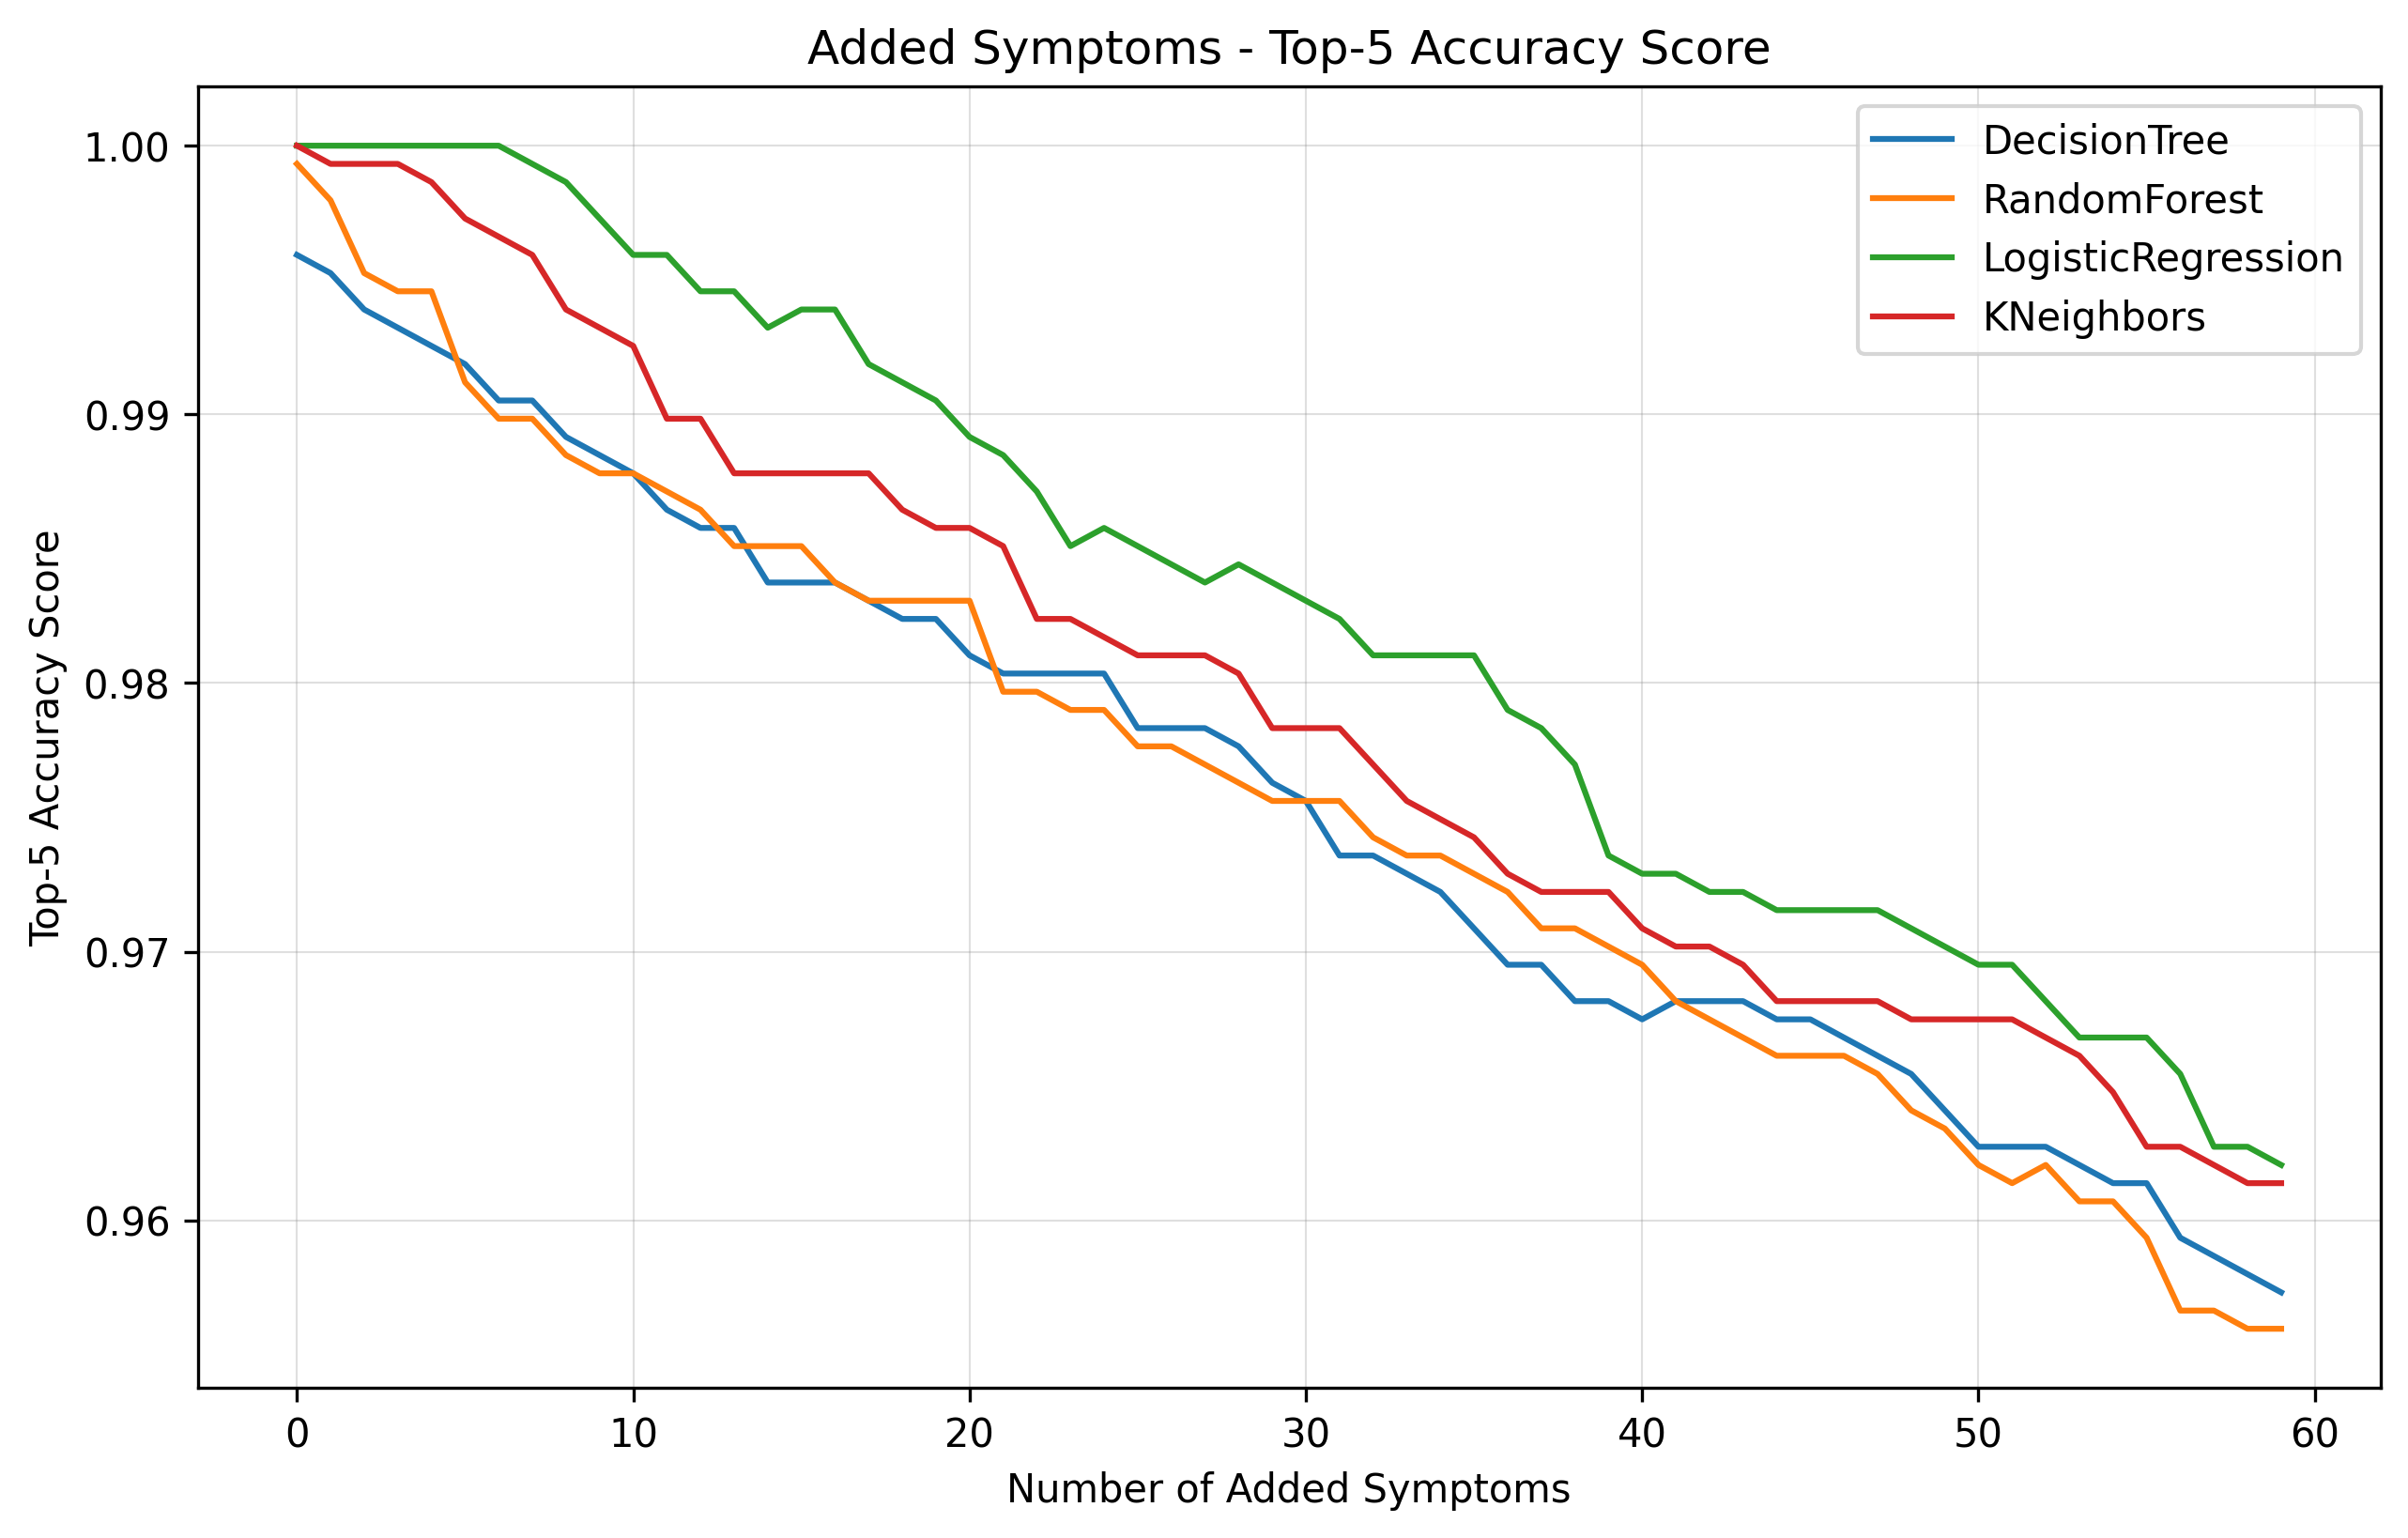

In [467]:
# Redefine binary dataframes
X_sub = binary.drop(columns=['Disease'])
y_sub = binary['Disease']

# Split the data into training and testing sets (70% train, 30% test)
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size = 0.3, train_size = 0.7, random_state = 42)

# Define maximum number of added symptoms
max_added_symptoms = 60

# Define array for accuracies
accs = np.empty((len(models), max_added_symptoms))
rocs = np.empty((len(models), max_added_symptoms))
topk = np.empty((len(models), max_added_symptoms))

acc_nn = []

# Iterate over each unique symptom
# for i in range(len(unique_symptoms)):
for i in range(max_added_symptoms):

    # Get indices where the symptom is not present
    # index, columns = np.where(X_test_sub == 0)
    # Choose a random symptom index from the columns where the value is 1
    # random_symptom_index = np.random.choice(columns)
    # Set the random symptom to 1 (present)
    # X_test_sub.iloc[:, random_symptom_index] = 1

    for _ in range(len(unique_symptoms)):

        index, columns = np.where(X_test_sub == 0)  # Get indices where the symptom is not present
        random_patient = np.random.choice(index)

        X_test_sub.iloc[index[random_patient], columns[random_patient]] = 1

    # Compute accuracies
    for j in range(len(models)):

        # Predict using the model
        predictions = models[j].predict(X_test_sub)
        # Evaluate the model
        accuracy = accuracy_score(y_test_sub, predictions)
        # Save the accuracy in the array
        accs[j, i] = accuracy

    # Compute ROC AUC and Top-K accuracy for each model (except SVC)  
    for j, model in enumerate(models):
        if model.__class__.__name__ != 'SVC': 
            y_scores = models[j].predict_proba(X_test_sub)
            roc_auc = roc_auc_score(y_test_sub, y_scores, multi_class='ovr', average='macro')
            rocs[j, i] = roc_auc

            topk_accuracy = top_k_accuracy_score(y_test_sub, y_scores, k=5)
            topk[j, i] = topk_accuracy

    # Compute predictions from neural network
    _, accuracy_nn = model_nn.evaluate(X_test_sub.values, LabelEncoder().fit_transform(y_test_sub), verbose = -1)
    # Append accuracy
    acc_nn.append(accuracy_nn)

# Setup figure size
plt.figure(figsize=(10, 6))

# Plot the accuracies
for k, model in enumerate(models):
    # Plot the accuracies for each model
    plt.plot(accs[k, :], label=model.__class__.__name__.split('Classifier')[0])
# Plot neural network accuracy
plt.plot(acc_nn, label = "NeuralNetwork")

# Accuracy plot
plt.title('Added Symptoms - Accuracy Score')
plt.xlabel('Number of Added Symptoms')
plt.ylabel('Accuracy Score')
# plt.ylim(0, 1)
plt.grid(visible = True, color = 'grey', alpha = 0.25, linewidth = 0.5)
plt.legend()
# Save figure
plt.savefig('./Plots/Classifier_Fulldata/added_accuracy.pdf')
# Show plot
plt.show()

# Setup figure size
plt.figure(figsize=(10, 6))

# Plot the ROC AUC scores
for k, model in enumerate(models):
    # Plot the accuracies for each model (ignore SVC)
    if model.__class__.__name__ != 'SVC':
        plt.plot(rocs[k, :], label=model.__class__.__name__.split('Classifier')[0])

# ROC plot
plt.title('Added Symptoms - ROC AUC Score')
plt.xlabel('Number of Added Symptoms')
plt.ylabel('ROC AUC Score')
# plt.ylim(0, 1)
plt.grid(visible = True, color = 'grey', alpha = 0.25, linewidth = 0.5)
plt.legend()
# Save figure
plt.savefig('./Plots/Classifier_Fulldata/added_roc.pdf')
# Show plot
plt.show()

# Setup figure size
plt.figure(figsize=(10, 6))

# Plot the Top-K scores
for k, model in enumerate(models):
    # Plot the accuracies for each model (ignore SVC)
    if model.__class__.__name__ != 'SVC':
        plt.plot(topk[k, :], label=model.__class__.__name__.split('Classifier')[0])

# Top-K plot
plt.title('Added Symptoms - Top-5 Accuracy Score')
plt.xlabel('Number of Added Symptoms')
plt.ylabel('Top-5 Accuracy Score')
# plt.ylim(0, 1.)
plt.grid(visible = True, color = 'grey', alpha = 0.25, linewidth = 0.5)
plt.legend()
# Save figure
plt.savefig('./Plots/Classifier_Fulldata/added_topk.pdf')
# Show plot
plt.show()